 <b><h1>Truel problem</h1></b><br>
 <div style="margin-left: 30px">
 <font color=blue size=5><b>Several people are doing duel. Given their probabilities to hit, what are probability of each of them to win and who should they choose as optimal initial target ?</b></font> <br>
    
 This is generalized version of original problem:<br>
    <ul>
        <li><i>N players</i>: generalization of fixed three participants in original problem - so technically this may not be "truel", although most of analysis is done for truel version </li>
        <li><i>Any hit probability</i>: unlike original problem which usually constrains 0 <= pA <= pB <= pC == 1, and especially makes it easier with pC fixed at 100%, this solution must support all possible hit probabilities in [0 .. 1] range for any player </li>
        <li><i>Optimal targets</i>: in addition to solving for predefined initial targets ( which is easier), this solution must be able to find optimal targets for any or all players - so initial targeting order is part of solution result, in addition to win probabilities </li>
        <li><i>Target selection</i>: to support different analyses, solution should be able to include or exclude different target options
            <ul>
                <li>Others:   standard target option, where player can select one among other players as target</li>
                <li>Miss:     player will intentionally miss (shoot at ground etc) </li>
                <li>Self:     player will shoot at himself ( suicide option ) </li>
                <li>Strongest:  player will shoot at highest threat - one of other remaining players with highest chance to hit </li>
                <li>Random:   player can, at each round, randomly select one of available target options to shoot at. This option should honor inclusion/exclusion of Others/Miss/Self/Strongest</li>
            </ul>
        </li>
    </ul>
 </div>
 <i>Original problem:</i> <br>
 <div style="margin-left: 30px">
 Three players are doing truel, where each can choose who to try to shoot, then next player plays and so on until only one winner is left. <br>
 If first player has 1/3 chance to hit, second has 2/3 and last has 100% chance to hit - what is chance of first player to win and who he should target at start ?<br>
 </div>
<br>


<b><h1>Summary</h1></b><br>
<ul style="font-size:18px">
<li>Problem definition</li>
<li><b>1. Solutions</b> - different ways to solve problem in <i>Python</i>
    <ul>
        <li>1.1 <i>Simulation</i> as approximate solutions for predefined target order - easier to make, but limited and slower execution </li>
        <li>1.2 <i>Mathematical calculation</i> for exact solutions with N players and can find optimal targets - more complex but also faster execution </li>
        <li>1.3 <i>Optimal targets</i> search - select optimal out of all possible targets, enhancimg simulation</li>        
    </ul>
</li>
<li><b>2. Visualizations</b> - Python functions that use one of solutions to visually present results for analysis
    <ul>
        <li>2.1 ptruel    - to find and print result for given hit probabilities and predefined or optimal targets</li>
        <li>2.2 ptruelWhy - to demonstrate "why" is target list returned in result really 'optimal'</li>
        <li>2.3 <i>testAB</i>    - to display results as colored graph image for any hit probability of first two players (A and B) on Y and X axis</li>
    </ul>
</li>
<li><b>3. Analysis</b> - using visualization tools to explore results given different situations and constraints in truel problem
    <ul>
        <li>3.1 Original problem - three players with hit probabilities [1/3, 2/3, 1], and allowed targets Others/Miss </li>
        <li>3.2 Miss target option - exploring in which scenarios allowing player to Miss changes result, and especially where it changes <i>optimal</i> targets solution</li>
        <li>3.3 Self target option - does it ever change optimal targets solutions, and how it influence results with predefined targets </li>
        <li>3.4 Random target option - where and why it change optimal targets solutions</li>
        <li>3.5 Four players - how different options influence four players version of truel</li>
    </ul>
</li>
</ul>


<b><h1>1. Solutions</h1></b>

While different functions will be used ( simulation, mathematical calculation, AB graphs), they all share certain input parameters - same way to define problem :

**function ( pHits, targets, search, ... )**

Explanation on main shared parameters:
* **pHits**: 
    - list of probabilities for each player to hit
    - size of list (or array) determines number of players, so for original truel problem it would have pHits=[ 1/3, 2/3, 1 ] 
* **targets**: 
    - list of predefined targets that each player will choose in initial phase of game ( while no player is eliminated yet )
    - it should have same number of elements as number of players, and for example targets= [ Miss, C, B ] indicate that player A will intentionally miss, while B and C shoot each other
    - default empty list means Optimal for all players
    - valid targets for each player are those that can be resolved to single player, or Random for equal chance to shoot any otehr player, or Optimal to find best target for that player
    - if 'Optimal' is selected as target for any player, solution ( if supported ) should find optimal targets for that player that will maximize players win probability
    - both Optimal and Random will use 'search' parameter to determine which targets are eligible/valid
    - constants usable in targets are defined/shown below : A,B,C ... Miss, Random, Self, Strongest, Optimal 
* **search**: 
    - list or set of valid targets for optimal search or random selection. 
    - default is search= [ Others, Miss ] , meaning players can target other players or intentionally miss, but can not target themselves or shoot randomly 
    - it uses same constants as those in 'targets' , except 'Optimal' (since this is used to find optimal). In addition, it can use 'Others' - meaning any player except shooter
    - for 3 player truel, this parameter is not used unless 'targets' list contains Optimal or Random. But for 4+ players it can be used even then - see 'Optimal search' section


In [406]:
# predefining constants to use as target types
class tg:
    A=0           # to allow use of [ tg.A ,..] instead of [ 0 ,.. ]
    B=1         
    C=2
    D=3
    E=4
    F=5
    G=6           # for players above 6, just use integer constants
    Miss=-1       # choose to intentionally miss or hit ground as target ( must be -1 since it is potential return target too )
    Random=-2     # randomly select target with equal chance out of all 'search' candidates except Random itself( must be -2 since it is potential return target too )
    Self=-3       # allow self shooting (suicide attempt) as valid target
    Strongest=-4  # choose one of other remaining players who has highest chance to hit as target
    
    Others=-5     # all other players are included in random/optimal search (can NOT be value in 'target' parameter, only in 'search' array )
    Optimal=-10   # instead of predefined target, find who is optimal target for this player ( can NOT be in 'search' parameter, only in 'target' array )
    
    All= [Others, Self, Miss, Random] # all possible target search options. It can be used directly (search=tg.All) or indirectly (search=[tg.All])


Constants for targets, and functions to sanitize and print hits, targets and search parameters:

In [408]:
import numpy as np    


# is time measured for individual functions
ShowTimes= True
# should truel calculations and simulations use math formula to shortcut 2 player cases
skip2players= True


# internal target types
class tg_:
    Invalid=-11 # internally used, do not pass in parameters
    All=[tg.Others,tg.Self,tg.Miss,tg.Random] # all possible target search options
    defaultSearch=np.array([tg.Miss, tg.Others] ,dtype=np.int32)  # by default, valid optimal or random targets are all other players and intentional miss
    defaultSearchLater=np.array([] ,dtype=np.int32)         # by default, search in later phases is same as in initial phase
    defaultTargets=np.array([],dtype=np.int32)              # default targets are not predeterminated, will search for optimal ( will expand to N*Optimal once N is known )    
    defaultTargetLater= tg.Optimal
    math=1  # calculation type for truel:  math= mathematical calculation
    sim=2   # calculation type for truel:  sim = simulation of the result

    
# targets as global constant version, for numba 
A=tg.A # warning: may be rewritten if variables A,B,C used !
B=tg.B
C=tg.C
D=tg.D
All= tg_.All
Miss=tg.Miss
Random=tg.Random
Self=tg.Self
Strongest=tg.Strongest
Optimal=tg.Optimal
Others=tg.Others
Invalid=tg_.Invalid
defaultSearch=tg_.defaultSearch
defaultSearchLater=tg_.defaultSearchLater
defaultTargets=tg_.defaultTargets
defaultTargetLater= tg_.defaultTargetLater





# convert targets to numpy array, and expand them to Optimal for all 'n' players if they were empty (default for unknown number of players)
# called only single time by top level user functions ( those that have default options ) to initially sanitize input, since it can not be numba ( due to taking lists and arrays as inputs )
def npTargets(targets, n):
    if type(targets) is set:
        print("Targets can not be set {} ! It must be list or array, where each position define target for that player. Converted to defaultTargets ")
        targets=[]
    if (len(targets)>0) and (len(targets)!=n):
        print(f"Targets size {len(targets)} is different from number of players {n} !  Converted to defaultTargets ")
        targets=[]
    if len(targets) == 0:
        ntargets= np.zeros(n, dtype= np.int32) # this approach since np.repeat uses int64, and we want int32
        ntargets += np.repeat(tg.Optimal,n) 
    else:
        # convert to list , then to np.array of type int32
        ntargets= np.array( list(targets), dtype=np.int32)
    # test for invalid values
    for i in range(len(ntargets)):
        t=ntargets[i]
        if t==tg.Others:
            print (f"target for player {i} can not be Others ! Set to Optimal. ")
            ntargets[i]=tg.Optimal
        elif t>=n:
            print(f"target for player {i} is {t}, which is larger than number of player {n} ! Set to Optimal. ")
            ntargets[i]=tg.Optimal
        elif (t<0) and not( t in [Miss,Self,Strongest,Random,Optimal,Others]):
            print (f"target for player {i} is {t}, which is unknown option ! Set to Optimal. ")
            ntargets[i]=tg.Optimal
    # return as numpy array
    return ntargets


# convert search set or list to numpy array
# called only single time by top level user functions ( those that have default options ) to initially sanitize input, since it can not be numba ( due to taking both sets or arrays as inputs )
def npSearch(search, allowPlayers=False):
    # flatten elements of list, if it was set inside list like [ {All}, Miss]
    sSearch= npFlatSet(search)
    # test for invalid cases
    if tg.Optimal in sSearch:
        print (f"search set can not contain Optimal ! Removed. ")
        sSearch.discard(tg.Optimal)
    sRes= sSearch.copy()
    for x in sSearch:
        if x>=0:
            if not(allowPlayers):
                print(f"search set can not contain specific players, since they may be eliminated during game ! Removed player {x} from set. ")
                sRes.discard(x)
        elif not(x in {Miss,Self,Strongest,Random,Optimal,Others}):
            print(f"search set contains unknown target option {x} ! ! Removed. ")
            sRes.discard(x)
    # convert to nparray
    nSearch= np.array(list(sRes),dtype=np.int32)
    return nSearch


# flatten nested lists, convert sets to lists etc
def npFlatSet( search ):
    # convert to list first, if it was set like { Others, Miss }
    if not( type(search) is list):
        try: # if element is set or array, or any other iterable, convert to list
            search=list(search)
        except: # if element was single value
            search=[search]
    # flatten elements of list, if it was set inside list like [ {All}, Miss]
    sSearch= set()
    for x in search:
        try: # if element is set or sub list, flatten
            sSearch.update(x)
        except: # if element was single value, add
            sSearch.add(x)
    # return set
    return sSearch


# convert single target integer to single character
def targetChar(target):
    target= int(target)
    if target>=0 :
        return chr(ord('A')+target)
    if target==tg.Optimal :
        return 'b'
    if target==tg_.Invalid :
        return 'i'
    tNames=['o','h','s','r','m']
    # Other, Strongest, Self, Random, Miss
    if (target>=-5) and (target<0):
        return tNames[target+5]
    return '?'
    
# convert targets array or list to string
def targetsStr(targets, brackets=True):
    res="[ " if brackets else ""
    for i in range(len(targets)):
        res += targetChar(targets[i])+" "
    res +="]" if brackets else ""
    return res

# convert search array or list or set to string, alllows nested list in list
def searchStr(search, brackets=True):
    search= npFlatSet( search )
    res="[ " if brackets else ""
    for x in search:
        res += targetChar(x)+" "
    res +="]" if brackets else ""
    return res


# convert probability array to string
def probStr(probs, brackets=True, perc=True, decimals=3):
    res="[ " if brackets else ""
    fd="{:7."+ ( str(decimals-2) if perc else str(decimals) ) +"f}"
    for i in range(len(probs)):
        p= probs[i]
        if perc:
            res+= fd.format(p*100)+"%"
        else:
            res+= fd.format(p)
    res +=" ]" if brackets else ""
    return res


<h2>1.1 Simulation as approximate solution</h2>

<h2>1.2 Mathematical calculation</i> for exact solutions</h2>

<b>Python function that solves truel problem for arbitrary number of players, and finds not only winning chances for each player but also optimal targets.<br></b>
<ul>
    <li><i>exact solution:</i>  returns exact mathematical solution, not approximate simulation result</li>
    <li><i>fast:</i>  computes fast even with 4+ players </li>
    <li><i>find optimal targets:</i> can find optimal targets for each player, with options to allow intentional misses (default), selftargeting, or even random targeting </li>
    <li><i>predefined targets as parameter:</i>also allows specifying fixed targets for some or all players (for initial rounds while all are alive)</li>
</ul>

<br>
<h>Solution reasoning:</h><br>
<div style="margin-left: 30px">
     if we have N players, with probability of i-th player (0..N-1) in pHit[i], then if i-th player is on move and he is targeting T:<br>
        &nbsp;&nbsp;&nbsp;&nbsp;<b>pwin</b>(i first out of N)= <b>pHit</b>[i]* <b>pwin</b>(i+1 first out of N-1, T is removed ) + (1-<b>pHit</b>[i])* <b>pwin</b>(i+1 first, out of N)<br>
     Assuming we can get exact result for reduced number of players (N-1), we can express solution for N players with i-th player on move as function of solution for (i+1)th player on move:<br>
        &nbsp;&nbsp;&nbsp;&nbsp; <b>pwin</b>(i)= <b>v</b>[]+ k*<b>pwin</b>(i+1)  , where <b>v</b>[]= constant vector with N elements = pHit[i]*pwin(i+1 first out of N-1, T is removed )  , and k= 1-ph[i]  ... so we can express this as tuple pwn=(v[], k)  so that pwin(i)=pwn*pwin(i+1)<br>
    <br><i>Infinite loop:</i>
     <div style="margin-left: 30px">
        Recursivelly calling pwin(i+1) will eventually get to last player, who will have to rely on first player result callin pwin(0) - which would result in infinite loop<br>
        That infinite loop can be avoided by passing function that express result for win probabilities if initial player is on move as function of win probabilities if (i+1)th player is on move : pwin(0)=pw0=  f( pwin(i+1) ) =  pwn * pwin(i+1) , with pwn= (v[],k ) <br>
        That pw0 can be modified by each succesive player, and when we get to last player and he recalculate pw0, he will have pw0= f ( pwin(N+1) ) = f ( pwin(0) ) ... or pw0 = f(pw0 ) which can be solved directly, avoiding infinite loop<br>
        Given pwn=(v[],k) and pw0= pwn*pw0=  v[]+k*pw0 ->   pw0(1-k)= v[] ->  pw0[]= v[]/(1-k)  ... resulting in probability to win for each player, if first to play is initial player <br>
        That exact result for pw0 can be now returned back to exactly calculate pwin(N-1), pwin(N-2)... all way back to pwin(0) which will get same result as pw0.<br>
    </div>
     <i>Finding who to target:</i>
     <div style="margin-left: 30px">
        above calculation assume that each player knows in advance who is best target for him to shoot at (T).  If he does not know that, he need to apply same calculation to every possible target (including no target) and select one which give him best chance to win<br>
        when 'no target' is selected, his chance to win is slightly different formula:  pwin(i)= pwin(i+1)   - or if we want to present in same format as before ( pwin(i)= v[]+ k*pwin(i+1) ), then v[]=[0,0..0] and k=1, or in tuple for ([0,0...0], 1.0)<br>
       special case is if everyone decide to skip (no target), which would lead to infinite loop, so need to be forbidden in some way. For example - last player is not allowed to skip if everyone else did it.<br>
    </div>
</div>



**truel**() function can be used to actually calculate win probabilities. It will initialize dictionary and check parameters before calling **nb_truel**, which is numba wrapper that calls truelC.  
Function **truelC** is main mathematical solution to recursivelly finds probability to win and optimal targets for each player.  
<br>
<i>Starting parameters:</i>
* pHit: list with probabilities of each starting player to hit  
* targets: list with predefined target for each player  ( default is Optimal for each player )  
* search:  what targets are allowed when searching for optimal/best or random target ( default= tg.Miss | tg.Others )  
* targetLater: what should all players select as target after initial phase (after one player is eliminated, and initial 'targets' become invalid . default= Optimal )
* searchLater: if search options in later phases (when some player was eliminated) should be different than in initial phase    

<i>Result:</i>  
* pw[]: probability of each player to win (given players shoot in pHits order) , array of float64 in [0,1] range
* tw[]: who is their initial target ( 0..n-1 index of player, or tg.Miss or tg.Random  ), array of int32 with target constants (-2,-1,0,1,2.. )


In [355]:
import numpy as np
import numba



# non-numba caller for truel, will check and sanitize inputs. Intended for direct usage by users, or functions that are making single call
def truel(pHits,   targets=defaultTargets, search=defaultSearch,    targetLater= defaultTargetLater, searchLater=defaultSearchLater, ifEQ=+1):
    # convert inputs to numpy arrays (if it was list) or create if empty
    n=len(pHits)
    ph= np.array(pHits, dtype=np.float64)
    ntargets= npTargets(targets,n)
    nSearch= npSearch(search)
    nSearchLater= npSearch(searchLater)
    # return 2D array float64 [[pw],[tw]]
    return nb_truel(pHits=ph, targets=ntargets, search=nSearch, targetLater= np.int32(targetLater), searchLater=nSearchLater, ifEQ=ifEQ )

    
# takes one case version, prepare additional parameters. Assume inputs are right type ( ph is 1d, np.arrays )
# Return 2d float64 array: [ pw[], tw[] ]
@numba.jit(nopython=True, nogil=True)
def nb_truel(pHits,   targets=defaultTargets, search=defaultSearch,    targetLater= defaultTargetLater, searchLater=defaultSearchLater, ifEQ=+1):
    n= len(pHits)
    # create default targets if empty (zeros+repeat, since repeat itself forces int64 )
    if len(targets)==0:
        targets= np.zeros(n, dtype= np.int32)
        targets += np.repeat(Optimal,n) 
    # if searchLater is empty (default), set it same as initial search options
    if len(searchLater)==0:
        searchLater= search
    # they shoot initially in order [0,1,2,...]
    o= np.arange(n , dtype=np.int32) 
    # initial solution vector
    pw0= ( np.zeros(n), 1)
    # max size of dictionary
    dMax=(n+1)**(n+1)
    # create cache dictionary
    dicValid= np.zeros(dMax,dtype=np.uint8)
    dicPW= np.empty((dMax,n),dtype=np.float64)
    dicTW= np.empty((dMax,n),dtype=np.int32)
    # call recursive truelC to really calculate results 
    r= truelC(pHit=pHits,  targets=targets,searchSet=search,   targetLater=targetLater,searchLater=searchLater,   o=o,c=n,pw0=pw0,ifEQ=ifEQ,   dicValid=dicValid,dicPW=dicPW,dicTW=dicTW)
    # cast result from tuple ( float64[], int32[] ) to single type array(2d,float64)
    res= np.empty((2,n), dtype=np.float64)
    res[0]=r[0]
    res[1]=r[1]
    return res
    
    

# Standard parameters:
#    pHit: array with probabilities of each starting player to hit. ph=[0.3,0.2,0.1,1] means there are 4 players initially
#    targets: array with initial targets (while all of them are still in game)  
#    search: what targets are allowed when searching for optimal or random targets
#    searchLater: if search options in later phases (when some player was eliminated) should be different than in initial phase

# Recursive parameters
#    o :  list of remaining players in order of shooting. Players are integer values,  A=0, B=1 ...
#    c :  number of remaining players to process before closing loop back to original player
#    pw0 : solution vector for win probabilities if initial player goes first, modified by all previous players

# Dictionary parameters
#    dicValid :  boolean array (uint8), with dicValid[key]==True if that value was already set/calculated
#    dicPW :     array of [float32] arrays, with win probabilities for each player. So for 3 players dicPw=[[0.1,0.7,0.2],[0.5,0.5,0.0],[...]] 
#    dicTW :     array of [int32] arrays, with selected targets for each player. So for 3 players dicTW=[[1,2,0],[0,2,-1],[...]] 


#@numba.jit('Tuple([float64[:], int32[:]]) ( float64[:], int32[:], int64, Tuple([ float64[:], int64 ]), int32[:], int32[:], int32[:],  uint8[:],float64[:,:],int32[:,:] )', nopython=True, nogil=True )
@numba.jit(nopython=True, nogil=True, fastmath=True)
def truelC(pHit,  targets,searchSet,   targetLater,searchLater,   o,c,pw0,ifEQ,   dicValid,dicPW,dicTW):
    # array lengths
    no=len(pHit) # starting number of players - results always have this many elements regardles of len(o)
    n=len(o) # number of players remaining in game
    m=o[0] # m= index of player on move 

    # check edge cases with single player, before cache
    if n<=1:
        bestPW=np.zeros(no, dtype=np.float64)
        bestTW=np.zeros(no, dtype=np.int32)
        if n==1: 
            # for n==1 , only player has 100% chance to win, and will target noone
            bestPW[m]=1.0 
            bestTW[m]= Miss
        # for n==0 leave all zero chances to win
        return (bestPW, bestTW)

    # check cache 
    key= np.int64(0)
    for i in range(n):
        key= key*(no+1) + o[i]+1
    if dicValid[key]>0:
        cPW,cTW= (dicPW[key], dicTW[key])
        return ( dicPW[key], dicTW[key] )

    # initial result
    bestPW=np.zeros(no, dtype=np.float64)
    bestTW=np.zeros(no, dtype=np.int32)
    phm= pHit[m] # probability of player on move to hit

    # check n=2 players edge case AFTER cache
    if (n==2) and skip2players : 
        # directly calculate. Stopping at n==2 is purely due to performance, since algorithm can terminate at n==1
        m2=o[1]
        p1=pHit[m]
        p2=pHit[m2]
        if (p1>0) or (p2>0):
            p= p1/(1-(1-p1)*(1-p2))
            bestPW[m]=p
            bestPW[m2]=1-p
        bestTW[m]=m2
        bestTW[m2]=m
    else:
    
        # make new order where next player goes first
        o2=np.append(o[1:],o[0])

        ### inner function that expand search option ( so Self becomes 0, Strongest become index in 'o' of player with highest threat etc)
        def expandSearch(sSet):
            sRes= set(np.copy(sSet))
            if Others in sRes: # if 'other players' are in set ( all except this player), those are indexes 1..n-1
                sRes.discard(Others)
                sRes.update(np.arange(1,n, dtype=np.int32))
            if Self in sRes: #if shooting at himself/suicide is allowed, replace with index 0
                sRes.discard(Self)
                sRes.add(np.int32(0))
            if Strongest in sRes: #if highest threat, find which one of players in 'o' has highest hit chance, beside current player
                sRes.discard(Strongest)
                hi, hiPHit= (0, 0.0)
                for i in range(1,n):
                    phi=pHit[o[i]]
                    if phi>=hiPHit:
                        hiPHit=phi
                        hi=i
                sRes.add( np.int32(hi) )
            return np.array(list(sRes), dtype=np.int32)


        # see if target was given or needs to be found
        trg = targets[m]
        if (trg == Optimal) or (trg==Random): # create list with valid search options for "find optimal" and "random"
            randomList= expandSearch(searchSet)
        if trg>=0: # if target is specific player, calc only for that target ( ignore miss/suicide/rnd limits, since this is given target )
            searchList= np.array([ np.where(o==trg)[0][0] ], dtype=np.int32) 
        elif trg== Optimal: # if target is "find optimal", use list from above
            searchList= randomList
        else: # if target is one of single target options like Miss, Strongest, Self  etc - transform it if needed (miss== idx 0, highest= find max etc )
            searchList= expandSearch(np.array([trg], dtype=np.int32))

        #### inner function that calculate coeficients (vs, ks, t ) for specific target index, using reduced number of players without that target ( target is given as index in 'o' ! )
        # calculate win probabilities if player *hits* his target
        def coefsTarget(i):
            if i== Miss:
                t= Miss
                vs=np.zeros(no)
                ks=1
            else:
                t=o[i]
                # make reduced player list (without player 'i'), starting with next player ( so remove i-1 )
                o2r= np.delete(o2,i-1)
                # probabilities to win if o[0] hits o[i] - reduction to one less player.  Remove fixed targets, since those were valid only while all players were alive
                pwM,_=truelC(pHit,    targets=np.repeat(targetLater,no),  searchSet=searchLater,     targetLater=targetLater,searchLater=searchLater,    o=o2r,c=n-1, pw0=( np.zeros(no), 1),ifEQ=ifEQ,    dicValid=dicValid,dicPW=dicPW,dicTW=dicTW)
                # pwin(if targeting i )= p_hit*pwin(without i,n-1)+ (1-p_hit)*pwin(if next starts,n)
                vs=phm*pwM
                ks=1-phm
            return (vs,ks,t)

        #### inner function that calculate win probabilities (pw, tw, valid), given coeficients (vs,ks,t) and target t
        # calculate win probabilities if player *miss* his target, then combine with supplied probabilities if player hits (in coefs)
        def oneTargetCoefs(coefs):
            vs,ks,t=coefs
            v0,k0=pw0
            pw0n=(v0+k0*vs, k0*ks)
            # calculate probability if missed and next player is on move
            if c>1:
                pwN, tw= truelC(pHit,   targets=targets,searchSet=searchSet,    targetLater=targetLater,searchLater=searchLater,    o=o2,c=c-1,pw0=pw0n,ifEQ=ifEQ,     dicValid=dicValid,dicPW=dicPW,dicTW=dicTW) # recursive call
            else:
                # last player in circular list - he would rely on first player result (infinite loop if recursive call), but we use it to calculate exact 1st player chance as pwN
                # pw0= pw0n*pw0 = v0f+ k0f*pw0 ->  pw0(1-k0f)= v0f ->  pw0= v0f/(1-k0f)  ... and we store pwN= pw0
                v0f,k0f=pw0n
                if k0f<1 :
                    pwN= v0f/(1-k0f)
                else:
                    return (np.zeros(no),np.zeros(no, dtype=np.int32),False)
                tw= np.zeros(no, dtype=np.int32)
            # now finalize probabilities and targets for player o[0] if he targets player 't'
            pw=vs+ks*pwN
            tw[m]=t
            return (pw,tw,True)

        #### inner function that calculate win probabilities (pw, tw, valid) for specific target , given target index ( target is given as index in 'o' ! )
        def oneTarget(i):
            # calculate win probabilities if player hits intended target
            if i == Random:
                # random target, any allowed target except again random
                vs=np.zeros(no)
                nt=0
                for u in randomList:
                    if u!= Random:
                        cf=coefsTarget(u)
                        vs+=cf[0]
                        nt+=1
                if nt>0:
                    vs/=nt
                # composite coeficient if all valid targets have equal random chance
                coefs= (vs, 1-phm, Random)
            else:
                # regular targets or -1 as miss
                coefs=coefsTarget(i)
            # calculate win probabilities if player miss, combined with coefs ( if played did hit )
            return oneTargetCoefs(coefs)

        # check each allowed target, and find best one
        bestP =-1
        for i in searchList:
            pw,tw,valid= oneTarget(i)
            if valid:
                p2= pw[m]
                isBetter=False
                if p2 > bestP:      # always better if higher win chance
                    isBetter=True
                elif p2 == bestP :  # if same win chance, compare target order - default is 'min' ( smaller target is better, so Random before Miss before A,B,C... )
                    t1= bestTW[m]
                    t2= tw[m]
                    if np.sign(t2-t1)*ifEQ > 0:  # ifEQ==-1 it will use default 'min', otherwise 'max'
                        isBetter=True
                if isBetter:
                    bestP=p2
                    bestPW=pw
                    bestTW=tw

    # store in cache (only for initial layer call) and return result
    res=(bestPW, bestTW)
    if c==n:
        dicPW[key]=bestPW
        dicTW[key]=bestTW
        dicValid[key]=1

    return res



#print("numba version:",numba.__version__)
#print("Threading layer chosen: %s" % numba.threading_layer())



<h2>1.3 Optimal targets</h2>

Finding optimal targets and win probabilities is more complex problem than just finding win probabilities for predefined initial targets.  


<h3><i>What are **"predefined targets"**  ?</i><br></h3>

Lets say that we have three players, customarily labeled as A (first to shoot), B (second to shoot), and C(third to shoot). And lets use probabilities to hit from original problem, so pA=1/3, pB=2/3 and pC=1.  
That could be written as pHits=[1/3,2/3,1] , where size of list determine number of players (here three), and players shoot in order of list ( so player A is represented by pHits[0], player B by pHits[1] etc ).  

Now let's say we want to solve problem where all players will always shoot at highest threat ( which, as further analyses will show, is most often optimal strategy ). In this case it means A and B will target C, and C will target B.  
That could be written as targets=[C,C,B]  or, using indexes of players with first player being at index 0, as targets=[2,2,1]. And that 'targets' list would represent "predefined targets" for this problem setup.  
But it is important to understand how and where those targets are used. Using them in initial phase of the game ( "game" refers to one duel/truel match until final winner is known ) is straightforward - and "initial phase" means that all players are still in game.  
In initial phase, player A will target C, when he miss then player B will target C, when B miss player C will target B, and when/if player C miss (not possible in case when pC=100%, but in general) then player A will again target player C.  
What happens when one player is eliminated?  Let's say player A hits player C, and only players A and B remain with player B on the move.  It is obvious that player B can not follow 'targets' any more, since playe C is eliminated.  
But what if player could follow 'targets' in next phase (after one player is eliminated)? Let's say our predefined targets were [Miss, C, B] , meaning player A would intentionally miss and players B and C shoot each other. Assuming player B hits player C, should player A still shoot to miss? Obviously not.  

Conclusion is that:

> <h4>'targets' only define what players will shoot in initial phase of game, while all players are still in game. As soon as one player is eliminated, 'targets' are not applicable any more.</h4>


Note that this holds true both for problem input ( predefined targets ) and problem result ( optimal targets ) - since "optimal targets" (as solution result), can be viewed as "predefined targets" that give best chance to win to all players.

This is often glossed over in Truel analyses, since for three players it is obvious that, when reduced to two players, optimal strategy is to shoot each other. Therefore specifying "targets" for truel completly define how each player will behave during entire game.  
But it is not so for more players. If we have four players with targets=[ D,D,D,C ] and player D is eliminated, what will remaining three players target in next phase? Clearly, old targets are not applicable, but neither is simple 'shoot each other' as in truel case.  
Therefore, predefined 'targets' parameter does <i>not</i> define all player choices in games with four or more players. To fully specify how four players should play it would need initial 'targets' while all are in game, and at least four additional 'targets' for each of four possible three player cases, and possibly even more than four - if player D is eliminated by player A (so now player B is on move), new targets could be [Miss,C,B,-]. But if player D was eliminated by player B instead ( so now player C is on move), it is possible that players would choose different target, for example [C,C,B,-]. At maximum that would mean 12 different possible 'targets' choices for three remaining players, depending on which player was eliminated and by who. This only gets more complex with 5+ players. So initial targets alone can not uniquelly define rest of the game, unless we assume that, as soon as one player is eliminated, players will select targets for next phase in some predefined way. Such predefined way could be "select highest threat", or "keep old target if alive, otherwise Miss" or even "all suicide" etc ... but most of them would not be logical choices since players would tend to select targets that maximize their chance for victory. In any case, choice for targetsLater, or targets to apply after on eplayer is eliminated, must be something applicable to all remaining players regardless of their number and of which players were eliminated. So it can not be "target player C" ( C could have been eliminated), or "Miss" (since it si pointless if all players miss).  

Valid options for **targetLater** would be:
- Strongest : everyone target strongest player
- Optimal:  everyone finds optimal target - this is most logical choice, and only one who allows to find optimal targets for 4+ players, so it is default 

It follows that:
> <h4> initial predefined 'targets' can define entire game only if we assume that, after one player is eliminated, remaining players will all select same type of target, specified in 'targetLater' - 'Optimal' should be default, with 'Strongest' as other option</h4>


<h3><i>What are **"optimal targets"**  ?</i></h3>

From above discussion, it follows that:

> <h4> "optimal targets" are predefined targets that would maximize victory chance of all players.</h4>

Since we have shown that 'predefined targets' only define initial phase ( while all players are still in game), that also holds true for 'optimal targets'. Similarly, if new 'optimal targets' are selected once one player is eliminated ( for example, from 4 to 3 players ), that new optimal targets will be valid only until next player is eliminated.


<h3>How to "maximize victory chance of all players" ?</h3>

Truel game is inherently **zero-sum game** ... if one player increase their chance to win, it must reduce some others player chance. Ultimately, sum of all players chance to win must be one:

$$ \sum_{player} pWin\, (player) = 1 $$


That presents problem to maximize victory chance for all players - if we maximize for player A, it will not be optimal for player B. But it is still possible to determine "optimal" targets if we make following assumptions:  
* Assumption: players are able to detect which target players before them have selected. This is straightforward, and can either work by assuming players can 'see' what others shot, or by some other means like each player must announce his target before he shoots.
* Assumption: it is possible to calculate win probabilities given predefined targets. This is even more straightforward, since it is main assumption of entire 'Truel' problem.

We need some way to reduce complex problem of 'find optimal targets' to simpler problem of 'find probabilities to win for predefined targets', using #6 assumption.  
<br>

> <h4> finding optimal targets can be solved using form of **minimax approach**:  </h4>

Last player to shoot (player C in three players example) will see targets of A and B ( assumption #5 ), and would be able to calculate his optimal target by calculating win probabilities for series of predefined targets ( assumption #6), where those predefined targets will always have same targets selected by A and B, and his own targets will be his every possible target option. Let's say that A selected tgA, B to shoot tgB ... and possible targets for C are A/B/Miss, and he will calculate three times:  
- for targetsC1= [ tgA, tgB,  A], winProbabilities=[ pwA1, pwB1, pwC1 ]  
- for targetsC2= [ tgA, tgB,  B], winProbabilities=[ pwA2, pwB2, pwC2!! ]  
- for targetsC3= [ tgA, tgB,  Miss], winProbabilities=[ pwA3, pwB3, pwC3 ]  

Player C will obviously select for his target option where his pwC is maximal ( for example, one marked with exclamation marks !! ).  He needed 3 calculations for that.

How does that influence selection process of player B?  
When player B is on the move, he knows what is target of player A (tgA ), and he also can analyse each of his possible choices. But for each of his choices, he needs to analyse potential responses of player C, in the same way that C would reason it from above. he will need 9 calculations (3x3):
* for targetsB1= [ tgA, A, * ] -> B can expect pwB12, since C will choose pwC12 as his maximum
    - for targetsC11= [ tgA, A, A ], winProbabilities=[ pwA11, pwB11, pwC11 ]  
    - for targetsC12= [ tgA, A, B ], winProbabilities=[ pwA12, pwB12, pwC12!! ]
    - for targetsC13= [ tgA, A, Miss ], winProbabilities=[ pwA13, pwB13, pwC13 ]
* for targetsB1= [ tgA, C, * ] -> B can expect pwB22!!, since C will choose pwC22
    - for targetsC11= [ tgA, C, A ], winProbabilities=[ pwA21, pwB21, pwC21 ]  
    - for targetsC12= [ tgA, C, B ], winProbabilities=[ pwA22, pwB22, pwC22!! ]
    - for targetsC13= [ tgA, C, Miss ], winProbabilities=[ pwA23, pwB23, pwC23 ]
* for targetsB1= [ tgA, Miss, * ] -> B can expect pwB33, since C will choose pwC33
    - for targetsC11= [ tgA, Miss, A ], winProbabilities=[ pwA31, pwB31, pwC31!! ]  
    - for targetsC12= [ tgA, Miss, B ], winProbabilities=[ pwA32, pwB32, pwC32 ]
    - for targetsC13= [ tgA, Miss, Miss ], winProbabilities=[ pwA33, pwB33, pwC33 ]
* therefore B chooses max ( pwB12, pwB22, pwB33 ), and if it turns to be pwB22, then B chooses 'C' as target. It also means that C will choose 'B' as target ( due to pwC22 ), and that predefined target is [ tgA, C, B ]

Same logic now extend to player A.  He needs to evaluate each of his target options tgA in { Miss, B, C }, and for each of them repeat logic that B would apply, so he will need to do 27 calculations (3x3x3).  
After determining what targets would B and C choose if he select each of his targets, he select one where he has maximal win probability. Note that it may not ( and in many cases will not ) be situation where player A has best win probability of all players. It will merely be one of three options where he has largest probability.
    

<h3>What if different targeting options are available ?</h3>


It should not change logic, it will only change number of available target options for each player. For example, if players can target themselves (with Self option), they will have 4 target options at each step, so player C will examine 4 cases, player B 4x4 and player A 4x4x4  
In general, there will be $ T^N = TargetChoices ^ {Players} $ cases .

If 'Random' option is available, where players can randomly shoot at any other player each round, it can be considered just as another option - as long as we know how to calculate win probabilities when Random is included in predefined targets, for example targets=[ Random, C, B ]

Same approach can be applied for cases where only some players are allowed to search for optimal target, and other players are fixed to predefined targets. Lets say that we have:  
- predefined targets = [ Optimal, C, Optimal ]

In this case, player A and C can choose any target, but player B must shoot at player C. It only changes step for player B ( who does not have anything to choose ), and player A will need smaller number of total calculations to find optimum (3x1x3=9).  
Basically, different options will change total number of possible 'predefined targets', but logic of choosing optimal targets after that should be same application of minimax.

Conclusion:

> <h4> Optimal targets can be found by using minimax approach on all possible combinations of specific predefined targets  </h4>


<h3>Is same approach to find optimal targets applicable both in mathematical calculations and in simulations ?</h3>

In essence, yes.  
Simulations need to use this approach just as explained, by simulating all possible predefined targets combinations (27 in above example), and then applying this approach to find optimal target.  
Mathematical calculation can do the same, but also has an option to optimize calculation and at same time calculate for optimal and for specific targets, as explained in later section.

So simulating for targets=[Optimal, Optimal, Optimal ] will generally takes 27x more time than for specific predefined targets=[ Miss, C, B ]. Even more for more target options, for example if target options are { Others, Self, Miss, Random }, which means 5 target options ( A,B,C,Miss,Random), then it needs 5^3= 125 more calculations to find optimal solution than to find one specific solution using simulations. Using optimized mathematical calculations would need somewhat more time for finding optimal solution, but not proportional to Targets^Players.




<h3>Possible target choices</h3>

Options when defining predefined targets or possible targets in optimal searches. Each constant is usable by tg.Name, or directly by name (except A..G). There are three places where these constants are applicable:  
* predefined '**targets**' : what targets will each player select in initial phase of game. It can be single specific player ( A, C ...), option that evaluate to single choice ( Self, Strongest, Miss ) or group choice ( Random, Optimal ).  It can not be Others, since it must be reducable to single target.<br>This is array of values, where each value define initial target for that player. So targets = [ Miss, C, Optimal ] means that initially player A will miss, player B will shoot player C, and player C will find optimal target for himself.
* '**search**' options : what targets are eligible when player is searching optimal target or shooting random target. Unlike for 'targets', it can be Others - since it define set of options. But it can not be Optimal , since it is used to find optimal.<br>This is basically set of values, that together define valid targets for all players. It can be represented as set or array, so search = { Others, Miss } = [ tg.Others, tg.Miss] means that when players look for optimal target , they can choose among other players or to miss.

* **result** 'targets' : part of solution result, it shows optimal targets as found by solution ( or passed predefined targets if no optimal option was present ). It can have same values as predefined target, except Optimal - whole idea of solution is to find what was that 'optimal' target and to replace it in predefined targets.<br>
This is array of values, where each value define optimal initial target for that player. So result targets = [ Miss, C, B ] means that solution kept supplied [ Miss, C, -] targets for A and B, and found that optimal initial target for C is 'B'


Constants defining possible targets, and functions to sanitize 'targets' or 'search' inputs and convert them to numpy arrays, and to convert target names:

**allTargetOptions** is function that generate **all possible specific targets** , based on predefined 'targets' and 'search' options for valid targets, and probability to hit of each player

Function <b>selectOptimalResult</b> is used to <b>select optimal targets among all possible </b>
- finds optimal targets among supplied list of target candidates and their results, using minimax approach
- returns single result with optimal targets
- optionally can print all options and indicate reasons why this result is optimal, which is used by ptruelWhy 


In [290]:
# enumerate all valid target options ( with specific 'single' targets including players/Miss?random ), based on predefined 'targets' constraints and allowed 'search' options for optimal targets
#  - targets:  list or array with predefined target option for each player. If 'Optimal', then it will be unrolled to all possible combinations
#  - search:  set or list or array with allowed targets for Optimal search. 
#  - pHits:   probabilities of each player to hit , needed to determine 'Strongest' if present
# return 2D array: res=[ nOptions, nPlayers ], or res[k]= k-th targets option
def allTargetOptions(pHits, search, targets  ):
    # sanitize targets and search and covnert to numpy arrays
    n=len(pHits)
    ntargets= npTargets(targets,n)
    nsearch= npSearch(search)
    # create allowed search options for each individual player - since their Others/Self differ
    playerOptions= []
    for i in range(n):
        searchOpt=[]
        for x in nsearch:
            if x==tg.Others:
                # add all 0..n-1, except 'i'
                searchOpt.extend(range(0,i))
                searchOpt.extend(range(i+1,n))
            elif x==tg.Self:
                # add player 'i'
                searchOpt.append(i)
            elif x==tg.Strongest:
                # find which player has highest threat in pHits, except 'i'
                hi, hiPHit= (0, 0.0)
                for u in range(n):
                    if (u != i) and ( pHit[u] >= hiPHit ):
                        hiPHit= pHit[u]
                        hi=u
                searchOpt.append(hi)
            else:
                # for any other option like Miss/Random
                searchOpt.append(x)
        # sort player options before appending
        searchOpt.sort()
        playerOptions.append(searchOpt)
    ## inner recursive to replace any Optimal with all possible values, returning list of targets ( list of nparrays)
    def replaceOptimals(t):
        # find first Optimal
        wOpt= np.where(t==tg.Optimal)[0]
        if len(wOpt)==0:
            return [t]
        # index of first player with Optimal option
        op=wOpt[0]
        # replace first optimal with all valid values
        res=[]
        for x in playerOptions[op]:
            nt= t.copy()
            nt[op]=x
            nRes= replaceOptimals(nt)
            res.extend(nRes)
        return res
    # call recursive function
    return replaceOptimals(ntargets)
            

# Function to calculate probability values for  all possible specific targets. Uses later defined truel(), needed here to demonstrate selection
# returns res= ( T, 2, n ) array, for T different predefined targets and 'n' players, with res[i,1] being i-th 'targets' and res[i,0] i-th win chances. 
def allTargetResults(pHits, search, targets ):
    # get all possible specific default target combos, with 'Optimal' replaced
    allTargetCombos= allTargetOptions(pHits, search, targets )
    # for each of them, calculate result and return 
    N=len(allTargetCombos)
    n=len(pHits)
    res=np.empty((N,2,n), np.float64)
    for i in range(N):
        r=  truel(pHits, targets=allTargetCombos[i], search=search)
        res[i,1]= allTargetCombos[i]
        res[i,0]= r[0]
    return res

        
    
    
def selectOptimalResult( allResults , ifEQ= +1, legend=False):
    # determine number of players and potential targets
    N= len(allResults)
    if N==0:
        return
    n= len(allResults[0,0])
    # string list to store explanatory comments
    guide= np.empty(N,dtype='object')
    for i in range(N):
        guide[i]=''
    
    ### recursive function for specific player to return best target for himself, given previously selected targets
    #  - player: current player that needs to decide
    #  - targetsSoFar : selected targets by previous players, so only [0:player-1] is valid
    # returns index in allResults that he would choose, and annotate 'guide'
    def minmax(player, targetsSoFar):
        # find cip= all combos that are still in play = all that start same as targetsSoFar[0:player]
        mask= np.all( allResults[:,1,0:player]== targetsSoFar[0:player] , axis=1) 
        cip= np.where(mask)[0] # indices of rows that satisfy condition
        if len(cip)==0:
            # no row satisfy condition, this should be invalid situation!
            return -1
        elif len(cip)==1:
            # only one row satisfy condition, so this player must plays that. If this is not beyond last player, comment on it
            idx= cip[0]
            if (player<n) and legend :
                guide[idx]+= targetChar(player)+"! "  # ! means player had only this as choice, so no choice actually
            return idx
        # find all unique possible options for player in this case (it may or may not be equal to options for this player in all cases)
        pop= list(set(allResults[mask][:,1,player]))
        bestP=-1
        idx=-1
        for i in range(len(pop)):
            # call recursively next player to decide what he would choose if this player chose pop[i]
            targetsSoFar[player]= pop[i]
            r= minmax(player+1, targetsSoFar) 
            # is this better option for this player?
            if (r>0):
                p2=allResults[r,0,player]
                if p2 > bestP :
                    # if better win chance, it is always better option
                    bestP=p2
                    idx=r
                elif p2 == bestP:
                    # if same win chance, compare targets
                    t1= allResults[idx,1,player]
                    t2= allResults[  r,1,player]
                    # if new target is smaller than old, select it ( if default selectIFEQ < 0 ), otherwise select larger target
                    if np.sign(t2-t1)* ifEQ > 0:
                        bestP=p2
                        idx=r
        # notify in guide which option he would choose
        if legend :
            guide[idx]+= targetChar(player)+"+ "  # + means player had selected this option as best (maximal probability for given previous choices )
        return idx
    
    # call recursive function for first player A
    idx= minmax(0, np.zeros(n))
    # function to print one row
    def prow(ir):
        print(" "+"{0:4}".format(ir+1)+('*' if ir==idx else " ")+" |   " + targetsStr(allResults[ir][1], brackets=False)+" | "+ probStr(allResults[ir][0],brackets=False) +"    |   "+ guide[ir])
        
    # if legend=True, display all possible options and their comments
    if legend==True:
        print(f"Legend:  * = best result, at #{idx+1}. m = Miss, r = Random.  Comment:  B must choose best among C+ ( those preferred by C ), and A must choose best among B+ ")
        print()
        print("    #  |  Targets |     win probabilities       |  + = max , ! = only  ")
        print("-------------------------------------------------------------------------------")
        for i in range(N):
            prow(i)
        print("-------------------------------------------------------------------------------")
    # return best solution row
    return allResults[idx]    

<b><h1>2. Visualization</h1></b>

<h2>2.1 <b>ptruel</b>    - to find and print result for given hit probabilities and predefined or optimal targets</h2>

<br>Helper <b>ptruel</b> (pHits, targets, search) function used to invoke single truel() calculation and pretty print result. <br>
It accept same starting parameters as truel(), and return same result (but only for single case , ie single set of probabilities )
In addition it display result as :  pHit%= [,,..] pWin%= [,,..] targets= [,,..] tm= h:mm:ss.ms &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ; win probabilities are rounded to one decimal, and targets are final/optimal targets for each player (tw[]) zero based. Asterix (*) denote that target was forced as parameter.<br>

In [356]:
import datetime


# Time and print truel result
# find probability for each player to win truel, given chances to hit - if they shoot in order with [0] first
def ptruel(pHits, targets=tg_.defaultTargets, search=tg_.defaultSearch, targetLater=tg_.defaultTargetLater, searchLater=tg_.defaultSearchLater,ifEQ=1, timeit=False):
    t0=datetime.datetime.now()
    r=truel(pHits=pHits, targets=targets,search=search,  targetLater=targetLater,searchLater=searchLater, ifEQ=ifEQ ) # call recursive solution
    # put asterix in front of predefined targets
    if len(targets)==0:
        ts=targetsStr(r[1])
    else:
        ts=""
        for i in range(len(targets)):
            ts=ts+", "+("" if targets[i]==tg.Optimal else "*")+targetChar(r[1][i])
        ts="["+ts[1:]+" ]"
    print(" pHit% ",probStr(pHits),":  pWin%= ",probStr(r[0]),"  targets= ",ts,( "tm="+str(datetime.datetime.now()-t0) if timeit else ""))
    #return r

<br>Solution to original problem, where first player can hit in 1/3 cases, second player in 2/3 cases and last player always hit - and program is allowed to find optimal targets for each player:<br>
<div style="margin-left: 30px">   
    <ul>
    <li>best for first player is to <b>intentionnally miss</b> ( 'm' as first value in targets )</li>
    <li>his probability to win is 39.7% ( first value in pWin%[] ) ... in fact, first player has highest win probability of all 3 players</li>
    <li>best target for other two players are each other ( second player shoot third and vice-versa )</li>
    </ul>
</div>

In [357]:
ptruel([1/3,2/3,1])

 pHit%  [    33.3%   66.7%  100.0% ] :  pWin%=  [    39.7%   38.1%   22.2% ]   targets=  [ m C B ] 


<br><br>Example that demonstrate how truel() can find optimal solution for generalized problem with N players - here with 4 players, each 25% better shot than previous.<br>
<div style="margin-left: 30px">   
    <ul>
    <li>best for first player is to shoot last player, and he has 22.2% chance to win</li>
    <li>best for second player is to shoot first player, and he has 41.8% chance to win - most of all players</li>
    <li>best for third player is to shoot last player, and he has 27.8% chance to win</li>
    <li>best for last player is to shoot third player, and he has only 8.2% chance to win - least of all players, even if he is best shot</li>
    </ul>
</div>

In [8]:
ptruel([1/4,1/2,3/4,1])

 pHit%  [    25.0%   50.0%   75.0%  100.0% ] :  pWin%=  [    22.2%   41.8%   27.8%    8.2% ]   targets=  [ D A D C ] 


<br>Same example as above, but we force all to shoot at highest shot, so B and C shoots D, D shoots C, allowing only first player A to find optimal target.<br>
Now first player is better ( at 34% chance to win ) but second player is worse and now best chance to win has thord player with 38%.

In [9]:
ptruel([1/4,1/2,3/4,1],targets=[ Optimal, Strongest, Strongest, Strongest ]);
ptruel([1/4,1/2,3/4,1],targets=[ Optimal, D, D, C ]);

 pHit%  [    25.0%   50.0%   75.0%  100.0% ] :  pWin%=  [    34.2%   24.2%   38.0%    3.5% ]   targets=  [ D, *D, *D, *C ] 
 pHit%  [    25.0%   50.0%   75.0%  100.0% ] :  pWin%=  [    34.2%   24.2%   38.0%    3.5% ]   targets=  [ D, *D, *D, *C ] 


<h2>2.2 <b>ptruelWhy</b> - to demonstrate "why" is target list returned in result really 'optimal'</h2>

Function <b>ptruelWhy</b> to generate all possible target combinations and <b>select optimal targets</b> among them , while printing all options and reasoning behind choices.
- uses allTargetResults function  to generate all posible target combinations and calculate their probabilities using truel() with all predefined targets
- uses selectOptimalResult function to find best target among all cancicates, using minimax approach
- print all options and indicate reasons why this result is optimal.


In [292]:

# Function to calculate and display optimal targets, with comments on selection reasons
def ptruelWhy(pHits, search=tg_.defaultSearch, targets=tg_.defaultTargets,ifEQ=1):
    ar= allTargetResults( pHits, search, targets)
    r=selectOptimalResult(ar, legend=True,ifEQ=ifEQ)
    print("Optimal/best result for pHits= ",probStr(pHits)," :  pWin= ",probStr(r[0]),"  targets= ",targetsStr(r[1]) )
    #return r


<h3>Example of minimax selection process for Optimal result</h3>

* using ptruelWhy function that actually calculate all probabilities for all possible target options for three players with hit chances pHits= [ 1/3, 1/2, 1] and possible targets { Others, Miss }
* it then uses minimax approach to select optimal targets for all players:
    - player C will, for each combination of targets selected by players A abd B before him, select one out of three target options ( Miss, A , B ) that gives him best result. So for cases # 1..3 , where A and B both choose to Miss, best option for C is # 3 ( to target B ) with 66% chance to win.  That option is marked by "C+". Similarly, if A and B selected [ Miss, C ] before him, his best option is # 9 ( 22% #9 > 11% #8 >> 0% #7 ), so he selects #9 in that case , etc...
    - player B can also select three options (Miss, A, C ) for every target that A select before him. But he knows that, for each of his selections, he can expect player C to select one of rows marked with "C+". So if player A selected Miss, player B can only choose among rows # 3,4,9 , and best win probability for him in that case is 38% at row # 9 , so he chooses that one (marked with B+). Similarly, if A select to target C, player B can choose among C+ rows at # 21,24,27 , where best result for him is at #27 with 54%, so #27 gets B+, and in similar way #18
    - when player A need to select his best target, he also have three options ( Miss, B , C ). For each of them he will get options marked by B+ from player B, so he needs to choose among three of those ( at riws #9, #18 and # 27 ), and best win probability for player A among those is one at row #9 with 39% chance.
    - therefore A chooses as his target Miss , B chooses to target player C, anc C chooses to target player B, or targets = [ m C B ] as shown in row #9, with win probabilities [ 39.7%   38.1%   22.2% ], meaning 40% chance for player A to win, 38% for player B and just 22% for player C
* if 'search' parameter is expanded to search=[Others,Miss,Self,Random] , then number of rows ( possible target combinations ) would increase to 125 ( 5^3). Or in general:    nTargetCombinations =  nTargetOptions ^ nPlayers 
    

In [126]:
ptruelWhy(pHits=[1/3,2/3,1],search=[Others,Miss])


Legend:  * = best result, at #9. m = Miss, r = Random.  Comment:  B must choose best among C+ ( those preferred by C ), and A must choose best among B+ 

    #  |  Targets |     win probabilities       |  + = max , ! = only  
-------------------------------------------------------------------------------
    1  |   m m m  |     0.0%    0.0%    0.0%    |   
    2  |   m m A  |     0.0%   66.7%   33.3%    |   
    3  |   m m B  |    33.3%    0.0%   66.7%    |   C+ 
    4  |   m A m  |     0.0%    0.0%  100.0%    |   C+ 
    5  |   m A A  |     0.0%   22.2%   77.8%    |   
    6  |   m A B  |    11.1%    0.0%   88.9%    |   
    7  |   m C m  |    42.9%   57.1%    0.0%    |   
    8  |   m C A  |    28.6%   60.3%   11.1%    |   
    9* |   m C B  |    39.7%   38.1%   22.2%    |   C+ B+ A+ 
   10  |   B m m  |     0.0%    0.0%  100.0%    |   C+ 
   11  |   B m A  |     0.0%   44.4%   55.6%    |   
   12  |   B m B  |    22.2%    0.0%   77.8%    |   
   13  |   B A m  |     0.0%    0.0%  10

<h2>2.3 <b>testAB</b>    - to display results as colored graph image for any hit probability of first two players (A and B) on Y and X axis </h2>

Functions in this area are intended to create AB image/graph showing how probabilities or optimal targets change for all possible ocmbinations of hit probabilities for first two players, A and B ( hence 'AB' in names )  
They can work for any number of players, using fixed hit probabilities for player C and above (players 3+), and exploring entire [0..1] range of probabilities for first two players A and B.
On all images Y-axis represent every possible probability 0%..100% to hit for player A (0% chance is bottom, 100% chance for A to hit is top ) and X-axis represent players B chance to hit ( 0% is left, 100% is right)  
Most functions share same parameters, that allows different data to be shown. Main AB functions are :  
* <font color=maroon><b>testABt()</b></font> has parameters passed in members of **test** class, either as single class or as list ( in which case <i>mulitple images</i> side-by-side are generated )
* <font color=maroon><b>testAB()</b></font>  has parameters passed individually, mandatory parameter **pHits** can be for N players ( default=[0,0,1]), and can be array for <i>mulitple images</i> side-by-side
* <font color=maroon><b>testAB1()</b></font> fixed for 3 players, loosing parameter pHits but with new optional parameter **pC**= list of probabilities for player C ( default pC=[1.0]) . If multiple pC, it create <i>mulitple images</i> side-by-side


<h4>Common parameters, either passed directly or as members of typed class <b>test</b>:</h4>

Initial three parameters are standard parameter passed to <i>truel</i> function:
* **pHits**: chance of each player to hit. Only chances for player C and above are used ( so pHits[2:] ), since pA and pB will be changing along Y-axis and X-axis. For real truel (3 players) typical pHits value here is [0,0,1]
* **targets**: predefined targets for each player. If not specified, optimal targets will be searched for players. Default = [] , meaning find optimal target for each player
* **search**: valid targets to choose when searching for optimal target or random target. Default = [ Others, Miss ]

Next three parameters are also passed to truel(), but are rarely changed from default. They define search/target behaviour after one player is eliminated :
* <font color=darkgrey><b>targetLater</b></font>: what will remaining players target in later phases of game, after some player is eliminated. Default= Optimal ( they will try to find optimal target )
* <font color=darkgrey><b>searchLater</b></font>: what will be valid targets for Optimal/Random search in later phases of game after someone is eliminated. Default = same as 'search' parameter
* <font color=darkgrey><b>ifEQ</b></font>: what target will player choose if both give him equal maximal win chance. Default = +1 , choose higher target first, player C,B,A,Miss,Random ( so exotic options chosen last). use ifEQ=+1 for opposite order

Following are ImageAB specific parameters:
* **points**: how many different pA and pB values to calculate. Resulting image will have points x points dimension - so higher points require more time to calculate.
* **AgtB**: if True (default), pA can be greater than pB - thus pA and pB will bot cover every possible value between 0.0 and 1.0 and image will be square. If False, pA < = pB and image will be bottom right triangle
* **method**: how to calculate truel probability values for each point:
    <ul>
        <li>'smart': (default) progressive resolution, calculating every point near edges using truel() function, and interpolating points in homogenous areas</li>
        <li>'normal': calculating every point using truel() function - slower than 'smart' option, and does not result in noticeable difference.</li>
    </ul>
* **intensityRange**: when probability is used for color intensity, determine where to have max/min intensity. Default is max intensity for pWin < = 40%, and min intensity for pWin > = 90%
* **colors**: how to determine color of points on image. Just initial letter of option is enough to pass in parameter. If passed as list , eg colors=['u','w'], it generate <i>multiple images</i> side-by-side
    <ul>
        <li>'winner': (default) color is based on which player has most chance to win at that point. Red for player A, Green for player B and Blue for player C. Intensity is brighter for lower chance to win, darker for higher chance to win.</li>
        <ul style="margin-left: 30px"> 
            <li><font color=red>Red</font>:   player A has highest chance to win</li>
            <li><font color=green>Green</font>: player B has highest chance to win</li>
            <li><font color=blue>Blue</font>:  player C has highest chance to win</li>
        </ul>
        <li>'pwin': color is based on best probability to win at that point , with gamut from black/blues for low probabilities to red/white for high probabilities.</li>
        <li>'unusualTargets': color is based on how unusual result targets are ( targets they will use while still alive ). When mulitple 'unusual' targets are present, most unusual one determine color in order:</li>
        <ul>
            <li><font color=green>green</font>: random target.</li>
            <li><font color=red>red</font>: self target / suicide </li>
            <li><font color=blue>blue</font>: intentional miss </li>
            <li><b>black</b>: other player, but not one with hihgest chance to hit</li>
            <li><font color=lightgrey><b>lightgrey</b></font>: other player who has highest chance to hit - there will be most of those. </li>
        </ul>
    </ul>



In [358]:
import typing

# typed class to be used for test parameters:  test( pHits=[0,1,1], points=200)
class Test(typing.NamedTuple):
    pHits:typing.List=[0,0,1]   # float64[]] - hit probabilities for each player, size determine number of players
    targets:np.ndarray=tg_.defaultTargets  # int32[] - initial targets for each player, default = [] which is expanded to [Optimal, Optimal, ...]
    search:np.ndarray=tg_.defaultSearch    # int32[] or {} - what targets are allowed when searching for Optimal or Random targets. Default = [ Others, Miss ]
    targetLater:np.ndarray=tg_.defaultTargetLater   # int32 - what players will target AFTER number of players is reduced. Default = Optimal
    searchLater:np.ndarray=tg_.defaultSearchLater   # int32[] or {} - allowed targets for optimal/random search AFTER number of players is reduced. Default = [] which means same as 'search'
    ifEQ:int= +1     # what target will player choose if both give him equal maximal win chance. Default = +1 , choose higher target first, player C,B,A,Miss,Random
    solution:int=tg_.math  # what is used to find truel solution: 'math' solves by calculation, 'sim' by random simulation
    AgtB:bool=True   # in AB functions, can player A have higher hit probability than player B. If True, full square is drawn. If False, only bottom right triangle is drawn, where pA <= pB <=1 
    intensityRange:typing.Tuple[float, float]=(0.4,0.9)    #  when colors represent winners, what range of win probability should map to intensity. Default is max intensity for pWin < = 40%
    points:int=300      # how many different pA and pB values to calculate. Resulting image will have points x points dimension 
    title:str=""        # custom title for individual image
    method:str='smart'  # for AB functions,  how to calculate truel probability values for each point. "smart" will calculate only where needed , and interpolate others, while "normal" will calculate all points
    colors:str='w' # for AB functions,  how to determine color of points on image:  'w'=winners, 'u'=unusual targets, 'p'= best win probability, 'tA'= player A targets, 'pA'=player A probabilities



Function that **calculate** result matrix [ points, points, 2, N ], with win probabilities and target orders for every mat[x,y] point:  

**makeMatAB** : create full matrix ( size x size ) with probabilities and targets for entire AB image area ( where Y axis represent probabilities of player A to hit, from 0.0 to 1.0 , and X-axis is same for player B ), using one of:
* **fixResolution** : create matrix by calling truel() calculation for every point, if method=="normal"
* **smartResolution** : create matrix by calling truel() calculation only for non-homogenous areas ( around edges or where targets change ), and interpolate for homogenous areas. faster than fixResolution, if method=="smart"
    - CalcMat: recursive function that determine if it can use interpolation or need to subdivide further
    - InterpolateMat: interpolation for homogenous areas ( with same win order )


In [423]:
import math
import time
import gc
from numba import prange

# calculate AB matrix, based on parameters
def makeMatAB(test):
    t0= time.perf_counter_ns()
    ph= np.array(test.pHits, dtype=np.float64)
    targ= npTargets( test.targets,len(ph))
    srch= npSearch(test.search)
    srchLater= npSearch(test.searchLater)
    # disable GC, since each of point x point pixels will create new array
    gcold = gc.isenabled()
    #gc.disable()    
    # calculate result matrix
    if test.method.lower().startswith('s'):
        # "smart" method: calculate at edges, interpolate between
        mat= smartResolution(  pHits=ph, targets=targ, search=srch,   targetLater=test.targetLater,searchLater=srchLater,ifEQ=test.ifEQ,  AgtB=test.AgtB, size=test.points )
    else:
        # 'normal' method, calculate every point
        mat= fixResolution(  pHits=ph, targets=targ, search=srch,   targetLater=test.targetLater,searchLater=srchLater,ifEQ=test.ifEQ,  AgtB=test.AgtB, size=test.points )
    tm=(time.perf_counter_ns()-t0)//1000000
    # reenable gc
    #if gcold:
    #    gc.enable()
    return mat, tm



# fixResolution: calculate full matrix ( size x size ) with results ( pWin[], targets[]) for each point
@numba.jit(nopython=True, nogil=True, fastmath=True)
def fixResolution( pHits,   targets,search,    targetLater,searchLater,ifEQ,   size, AgtB ):
    mat= np.full((size+1,size+1,2,3), Invalid, dtype=np.float64)
    n= len(pHits)
    for a in range(size+1):
        for b in range(size+1):
            if (a<=b) or AgtB:
                pHits[0]=a/size
                pHits[1]=b/size
                r= nb_truel(pHits,  targets=targets, search=search,   targetLater=targetLater,searchLater=searchLater,ifEQ=int(ifEQ)) 
                mat[a,b]=r
    return mat


# SmartResolution: calculate full matrix ( size x size ) with results ( pWin[], targets[]) for each point , using either calcMat or interpolateMat
def smartResolution( pHits,   targets, search,   targetLater,searchLater,ifEQ,    size, AgtB ):
    mat= np.full((size+1,size+1,2,3), tg_.Invalid, dtype=np.float64)
    n= len(pHits)
    # determine initial parts:  higher initial parts result in slightly slower execution, but better precision. 30 is ok even for lower resolutions, and later increases
    parts= max(30, math.ceil(size/40))
    calcMat(mat, size,n,parts,AgtB, 0,0, size,size, pHits,search,targets,  targetLater,searchLater,ifEQ=ifEQ)
    return mat


### helper functions for 'SmartResolution'

# interpolate rectangular area on result matrix (change probability values inside 'mat'), based on edges
@numba.jit(nopython=True, nogil=True, fastmath=True)
def interpolateMat( mat, a0,b0,  a1,b1):
    db=b1-b0
    if db<=0:
        return
    tg= mat[a0,b0][1] # homogenous area, means they all have same targets
    for a in range(a0+1,a1):
        pw0=mat[a,b0][0]
        pw1=mat[a,b1][0]
        dp=pw1-pw0
        for b in range(b0+1,b1):
            pk= (b-b0)/db
            pw= dp*pk+pw0
            mat[a,b][0]=pw
            mat[a,b][1]=tg
    return

# calculate rectangular area of matrix with results ( pWin[], targets[]) for each point
@numba.jit(nopython=True, nogil=True, fastmath=True, parallel=False)
def calcMat ( mat, points,n,parts,AgtB, a0,b0,  a1,b1,   pHits,search, targets,   targetLater,searchLater,ifEQ=+1):
    # if AgtB forced, skip rectangles entirely outside area
    if not(AgtB) and (a1>b1):
        return
    ### inner function to calculate fingerprint of result:  order of win probabilities and exact targets
    def FP(r):
        fp=0
        # order of win probabilities
        sortedPWidx= np.argsort(r[0]) 
        for i in range(n):
            fp=fp*n + sortedPWidx[i]
        # exact targets, possible 0..n-1 (for players, including self) and -1(==tg.Miss), -2(==tg.Random) .. so (n+2) possibilities
        tw=r[1]
        for i in range(n):
            fp=fp*(n+2) + (tw[i]+2)
        return fp
        
    ### inner function to calculate one point
    def calcPoint(a,b):
        pHits[0]=a/points
        pHits[1]=b/points
        r= nb_truel(pHits,  targets=targets, search=search,   targetLater=targetLater,searchLater=searchLater,ifEQ=int(ifEQ))   
        mat[a,b]=r
        return r
    ### inner function to check fingerprint of one point ( calculate point if needed )
    def checkFP(a,b):
        if mat[a,b,1,0]==Invalid:
            return FP( calcPoint(a,b) )
        else:
            return FP( mat[a,b] )
        
    # determine if this rectangle can do interpolation or need deeper calcMat
    Homogen=True
    minLimit= 4
    homValue= checkFP(a0,b0)
    if parts==0: # if parts are alreasy supplied, it assume non-nomogenity so skip this
        # what is minimal side size of this area
        minSize= min( a1-a0, b1-b0)+1  
        minFinal= (minSize <= minLimit)
        # calculate boundaries, to determine if area is homogenous
        # check if point is already calculated, and if it is homogenous
        def onePoint(a,b):
            if not(AgtB) and (a>b):
                return False
            fp= checkFP(a,b)
            return Homogen and (fp==homValue)
        # check top horizontal corners for homogenity        
        Homogen=onePoint(a1,b0)
        Homogen=onePoint(a1,b1)
        # check horizontal edges for homogenity        
        for a in range(a0,a1):
            Homogen=onePoint(a,b0)
            Homogen=onePoint(a,b1)
            if not(Homogen or minFinal):
                break
        # check vertical edges for homogenity        
        for b in range(b0,b1+1):
            Homogen=onePoint(a0,b)
            Homogen=onePoint(a1,b)
            if not(Homogen or minFinal):
                break
        # if it is homogenous area, use interpolation
        if Homogen:
            interpolateMat(mat,a0,b0,a1,b1)
            return
        # if no interpolation was possible, determine in how many parts to partition
        # if too small area, do direct calculation of each point (skip already calculated edges)
        if minFinal :
            # calculate for all points inside
            for a in range(a0+1,a1):
                for b in range(b0+1,b1):
                    if AgtB or (a<=b):
                        calcPoint(a,b)
            return
        else:
            # partition in enough pieces so that min size is under 8 points, but not more that 8 pieces per axis
            parts= min( math.ceil(minSize/minLimit) , 8 )
    #partition area to smaller ones and do deeper calcMat on them
    da= math.ceil((a1-a0+1)/parts)
    db= math.ceil((b1-b0+1)/parts)
    if (da<=0)or(db<=0):
        return
    for a in range(a0,a1,da):
        for b in range(b0,b1,db):
            # recursive call of calcMat for this subarea. Ensure edges overlap, to avoid double computations for fingerprints
            calcMat ( mat, points,n,0,AgtB,  a,b,  min(a+da,a1), min(b+db,b1),   pHits,search, targets,   targetLater,searchLater)
    return




Functions that create image from result matrix:  

* **makeImageAB** : create AB image from params ( using Fixed or Smart methods), and return  (image, label, title ). Can return multiple images, one for each option in 'colors'
    - **colorImageAB** : create image from matrix, based on 'colors' parameter
        - CalcMat: recursive function that determine if it can use interpolation or need to subdivide further
        - InterpolateMat: interpolation for homogenous areas ( with same win order )
* **horizImages** : display multiple results of makeImageAB horizontaly in same cell.

In [410]:
import math
import time

    
# create AB image from result matrix and return  (image, label, title ). Can return multiple images, one for each option in 'colors'
def makeImageAB(test, mat, tm0=0, isDiff=False):
    t0= time.perf_counter_ns()-tm0*1000000
    colors= test.colors
    # create image from probabilities and targets, one for each colors type
    if not(type(colors) is list):
        colors=[ colors ]
    res=[]
    n= len(test.pHits)
    for col in colors:    
        colIdx, player= colorsIdxP(col, n)
        gimage, score= colorImageAB(mat=mat, pHits=test.pHits, intensityRange=test.intensityRange, points=test.points, colorsAlg=colIdx, player=player )
        tm=(time.perf_counter_ns()-t0)//1000000
        t0= time.perf_counter_ns()
        # define label 1st line
        label="pA= Y axis, pB= X axis, pC"
        if (n>3):
            label += ".."+ chr(ord('A')+n-1)
        label += "= "+str( round(sum(test.pHits[2:])*100) )+"% "+ (" in "+str(tm)+"ms"  if ShowTimes and (tm>1 ) else "" )
        # define label 2nd line
        # check scores in given order, and attach names. Names are list of lists [['name11','nam112',],['name21','name22'],...] to allow for short and long names
        def scoreStr(names,order=[], showZero=False, decimals=1 , mult=1.0):
            if len(order)==0:
                order=np.arange(len(score))
            # create mulitple labels with different name sizes
            lres= ["" for i in range(len(names))]
            fd="{:0."+str(decimals)+"f}"
            for x in order:
                if (x< len(score)) and (x<len(names[0])):
                    if (score[x]>0) or showZero:
                        xs= "= "+fd.format(score[x]*mult)+"%" # f"={score[x]}% "
                        for i in range(len(names)):
                            lres[i]+= names[i][x]+xs
            # return first/longest one that is under 50 chars
            for lr in lres:
                if len(lr)<50:
                    return lr
            # if none is under 50, return last one
            return lres[-1]
            
        title=test.title
        label2=""
        inputTS="  t="+targetsStr(test.targets)+" s="+searchStr(test.search)
        if colIdx==0:
            if title=="":
                if isDiff:
                    title= "Player with highest DIFF"
                else:
                    title= "WINS "+inputTS
            label2 = scoreStr(names=[ ['A(red)','B(green)','C(blue)','D(purple)','E+(brown)'] ])
        elif colIdx==1:
            if isDiff:
                title= (f"pWin DIFF for player {targetChar(player)} [%]" if player>=0 else "pWin DIFF , worst case [%]") if title=="" else ""
                label2 = scoreStr(names=[ ['diff pWin(A)','diff pWin(B)','diff pWin(C)','diff pWin(D)','diff pWin(E+)'] ], decimals=12, mult=0.01)
            else:
                title= ("pWin "+( f"for player {targetChar(player)}" if player>=0 else "best")+ inputTS) if title=="" else ""
                label2 = scoreStr(names=[ ['pWin(A)','diff pWin(B)','diff pWin(C)','diff pWin(D)','diff pWin(E+)'] ], decimals=4)
        elif colIdx==2:
            if title=="":
                title="Unusual targets  "+inputTS
            label2 = scoreStr(names=[ ["Self(red)","Random(green)","Miss(blue)","LowHit(black)","rest(grey)"],  ["self(R)","random(G)","miss(B)","weak(blk)","rest(grey)"],  ["s(R)","r(G)","m(B)","weak(blk)","~(gry)"] ], order=[1,0,2,3,4] )
        elif colIdx==3:
            if isDiff:
                title= ("Targets DIFF for player "+targetChar(player)) if title=="" else ""
                label2 = f"Different target at {np.sum(score)} % points "
            else:
                title= ("TARGETS of player "+targetChar(player)+inputTS) if title=="" else ""
                label2 = scoreStr(names=[ ['Random(brown)','Miss(yellow)','A(red)','B(blue)','C(green)','D(purple)'] , ['r(brwn)','m(ylw)','A(red)','B(blu)','C(grn)','D(prpl)'] ])
        if label2 !="":
            label +="\n"+label2
        res.append((gimage, label, title ))
    return res




# index for color algorithm, based on first letter: 'w': 0 - winners (default), 'p': 1- pwin, 'u': 2- unusual targets, 't': 3 - player targets  
# subindex determine for which specific player, based on 2nd letter: -1= none, 0='A', 1='b'...etc. Not all coloring schemes suppor indexing ('w' and 'u' does not)
def colorsIdxP(colors, n):
    colorsIdx=-1
    subIdx=-1
    cs=colors.lower()
    # index, 1st letter
    if len(cs)>=1:
        ch=cs[0]
        if ch=='w':
            colorsIdx=0
        elif ch=='p':
            colorsIdx=1
        elif ch=='u':
            colorsIdx=2
        elif ch=='u':
            colorsIdx=2
        elif ch=='t':
            colorsIdx=3
    # subindex, 2nd letter
    if len(cs)>=2:
        chi=ord(cs[1])-ord('a')
        if (chi>=0) and (chi<n):
            subIdx= chi
    # check color index validity
    if colorsIdx<0:
        print ("Unknown coloring scheme ",colors)
    if (colorsIdx==0) and (subIdx>=0):
        print ("Coloring scheme 'w' ( winners ) can not have 2nd letter for player specification: ",colors)
    if (colorsIdx==2) and (subIdx>=0):
        print ("Coloring scheme 'u' ( unusual targets ) can not have 2nd letter for player specification: ",colors)
    if (colorsIdx==3) and (subIdx<0):
        print ("Coloring scheme 't' ( player targets ) must have 2nd letter for player specification: ",colors)
    # return index and subindex
    return colorsIdx, subIdx



# determine coloring algorithm and return (image, score)
def colorImageAB(mat, pHits, intensityRange, points, colorsAlg, player):
    ph= np.array(pHits, dtype=np.float64)
    n= len(ph)
    if colorsAlg==1:
        return nb_colorImageAB_pwin(mat, points, player)
    elif colorsAlg==2:
        return nb_colorImageAB_unusualTargets(mat, ph, points)
    elif colorsAlg==3:
        # player targets, create color scheme:  brown=Random, yellow=miss, red=A, blue=B, green=C, purple=D
        fixColors=np.array([(0x66, 0x33, 0x00),(0xff, 0xff, 0x00),(0xff, 0x00, 0x00),(0x00, 0xff, 0x00),(0x00, 0x00, 0xff),(0x99, 0x00, 0x99)], dtype=np.uint8)
        colors= np.empty((n+2,3), dtype = np.uint8)
        canFix= min(6,n+2)
        colors[:canFix ,:]=fixColors[: canFix]
        for i in range(6,n+2):
            colors[i,:]=np.random.randint(0,256,dtype=np.uint8)
        if player<0:
            player=0
        # call for it
        return nb_colorImageAB_Targets(mat, points, player, colors)
    else:
        return nb_colorImageAB_winners(mat, intensityRange, points)


# winners - players with highest win probability : red=A, green=B, blue=C, purple=D, brown=rest, black= over N   ;  scores are for those colors , 3D image
@numba.jit(nopython=True, nogil=True, fastmath=True)
def nb_colorImageAB_winners(mat, intensityRange, points):
    gimage = np.zeros((points+1, points+1,3), dtype = np.float32)
    n=len(mat[0,0][0])
    score=np.zeros(5) # 0=red,1=green,2=blue,3=black,4=grey , count colors
    tot=0
    cMin, cMax= intensityRange
    # process each point
    for a in range(points+1):
        for b in range(points+1):
                r=mat[a,b]
                if r[1][0]==Invalid:
                    gimage[a,b,:]=1.0
                else:
                    tot +=1
                    # 'winner': color is based on which player has most chance to win. Red=A, Green=B, Blue=C. Intensity is scaled to <cmin, cMax>, and brighter for lower chance to win
                    w= np.argmax(r[0])
                    pw1= r[0][w]
                    if (pw1>0):
                        p=1-(pw1-cMin)/(cMax-cMin)
                        if w<3:
                            score[w]+=1
                            gimage[a,b,w]= max(min(p ,1.0),0)
                        else:
                            # E+ are all counted as E: brown
                            gimage[a,b,:]= (0.2, 0.4, 0.0)
                    else:
                        # if max probability is zero, then all are zero - this is difference chart, so show white
                        gimage[a,b,:]=1.0

    if tot>0: # convert score to percentage
        score *= 100/tot
    return gimage, score


# probabilities to win - for best player if -1, or for specific player , 2D image
@numba.jit(nopython=True, nogil=True, fastmath=True)
def nb_colorImageAB_pwin(mat,  points, player):
    gimage = np.zeros((points+1, points+1), dtype = np.float32)
    n=len(mat[0,0][0])
    score=np.zeros(n) # how many times was he 1st place, 2nd, 3rd etc....TBD
    tot=0
    # process each point
    for a in range(points+1):
        for b in range(points+1):
                r=mat[a,b]
                if r[1][0]==Invalid:
                    gimage[a,b]=1.0
                else:
                    tot +=1
                    if player<0:
                        p= np.max(r[0])
                    else:
                        p= r[0][player]
                        score[player]+=p
                    gimage[a,b]= p
    if tot>0: # convert score to percentage
        score *= 100/tot
    return gimage, score



# most unusual targets of any player: green=Random, red=self, blue=miss, black= low threat, grey= rest   ;  scores are for those colors , 3D image
@numba.jit(nopython=True, nogil=True, fastmath=True)
def nb_colorImageAB_unusualTargets(mat, ph, points):
    gimage = np.zeros((points+1, points+1,3), dtype = np.float32)
    n=len(mat[0,0][0])
    score=np.zeros(5) # 0=red,1=green,2=blue,3=black,4=grey , count colors
    tot=0
    ar=np.arange(n)
    # process each point
    for a in range(points+1):
        for b in range(points+1):
                r=mat[a,b]
                if r[1][0]==Invalid:
                    gimage[a,b,:]=1.0
                else:
                    tot +=1
                    # 'unusualTargets': color is based on how unusual result targets are . When mulitple 'unusual' targets are present, most unusual one determine color in order
                    pw= r[0]
                    tg= r[1].astype(np.int32)
                    ### helper function to check if integer is in tg, since "if x in arr" does not work in numba
                    def inTg(x):
                        for i in range(n):
                            if tg[i]==x:
                                return True
                        return False
                    # check if any target is 'Random', as most unusual, and mark it Green
                    if inTg(Random):
                        col= (0,1,0) # green
                        score[1]+=1
                    else:
                        # check if anyone targets himself ( Self/Suicide), and mark it red
                        hasSuicide=False
                        for i in range(n):
                            if tg[i]==i:
                                hasSuicide=True
                        if hasSuicide:
                            col= (1,0,0) # red
                            score[0]+=1
                        else:
                            # check if anyone intentionally miss, and mark it blue
                            if inTg(Miss):
                                col= (0,0,1) # blue
                                score[2]+=1
                            else:
                                # check if anyone targets player who is not highest threat
                                ph[0]= a/points # recreate hit probabilities that were input for this point calculation
                                ph[1]= b/points
                                # for each player, see if his target is player, but NOT highest hitter
                                targetLower=False
                                for i in range(n):
                                    if (tg[i]>=0): # if this player target another player (it should, since miss and random are checked above)
                                        pmx=np.amax(ph[np.where(ar!=i)]) # highest hit chance apart from this players own
                                        if ph[tg[i]] < pmx: # he target someone with lower chance
                                            targetLower= True
                                            break
                                if targetLower:
                                    col= (0,0,0) # black
                                    score[3]+=1
                                else:
                                    # default 'usual' color
                                    col = (0.8,0.8,0.8)  # light grey
                                    score[4]+=1

                    # apply target color
                    gimage[a,b,:]= col
    if tot>0: # convert score to percentage
        score *= 100/tot
    return gimage, score


# targets of specific player: teal=Random, yellow=miss, red=A, blue=B, green=C, ...   ;  scores are for those colors, 3D image
@numba.jit(nopython=True, nogil=True, fastmath=True)
def nb_colorImageAB_Targets(mat, points, player, colors):
    gimage = np.zeros((points+1, points+1,3), dtype = np.uint8)
    n=len(mat[0,0][0])
    score=np.zeros(n+2) # how many times was each target selected
    tot=0
    # process each point
    for a in range(points+1):
        for b in range(points+1):
                r=mat[a,b]
                if r[1][0]==Invalid:
                    gimage[a,b,:]=0xff
                else:
                    tot +=1
                    t= int(r[1][player]+2)
                    if t>=0:
                        gimage[a,b,:]= colors[t]
                        score[t] +=1
                    else:
                        # differences are lowered by -1, so -1 here means no difference at targets
                        gimage[a,b,:]=0xff
                        
    if tot>0: # convert score to percentage
        score *= 100/tot
    return gimage, score






from matplotlib import pyplot as plt
from matplotlib import rcParams
from scipy.ndimage.filters import gaussian_filter

# plot multiple images in single row, taking list of [ tuple(image,label) ] as input
def horizImages(ImagesLabels, figTitle="", inches= 7):
    N= len(ImagesLabels)
    rcParams['figure.figsize'] = ((N+1)*inches, inches)
    fig, ax = plt.subplots(1,N, squeeze=False)    
    if figTitle != "":
        fig.suptitle(figTitle, fontsize=16)
    # create image data
    for i in range(N):
        image,label,title= ImagesLabels[i]
        # interpolation does not help much, since rectangles are larger than single pixels at low pA,pB resolutions
        im=ax[0,i].imshow( image, origin='lower', extent=	(-0.5, 100.5, -0.5, 100.5), interpolation='antialiased', cmap='viridis');
        ax[0,i].set_xlabel(label, fontsize=12)
        ax[0,i].set_title(title, fontsize=12)
        # determine if 2D image, to show colorbar
        if image.ndim==2:
            #plot = ax[0,i].pcolor(image)
            #fig.colorbar(plot)
            fig.colorbar(im,ax=ax[0,i], shrink=0.7)
    plt.show()


Implementation of functions :  
* <b>testABt()</b> has parameters passed in members of **test** class, either as single class or as list ( in which case <i>mulitple images</i> side-by-side are generated )
* <b>testAB()</b>  has parameters passed individually, mandatory parameter **pHits** can be for N players ( default=[0,0,1]), and can be array for <i>mulitple images</i> side-by-side
* <b>testAB1()</b> fixed for 3 players, loosing parameter pHits but with new optional parameter **pC**= list of probabilities for player C ( default pC=[1.0]) . If multiple pC, it create <i>mulitple images</i> side-by-side

**testABt**, used by all others, generate single image or up to cases x pHits in each case x colors images side by side:  
- parameters passed in members of **test** class, either as single class or as list ( in which case mulitple images side-by-side are generated )
- inside each test, pHits can be passed as list, again creating multiple images side-by-side
- for each individual pHits case, parameter colors can also be list, again generating mulitple side-by-side images



In [426]:
  
# generate single image, or up to cases x pHits in each case x colors images side by side:
# parameters passed in members of **test** class, either as single class or as list ( in which case mulitple images side-by-side are generated )
# for each individual test case, parameter colors can also be list, again generating mulitple side-by-side images
def testABt(cases, title="", inches= 7):
    # convert single test case to list
    if not(type(cases)== list ):
        cases= [ cases ]
    # process each case and add to list of images and labels
    ImagesLabels=[]
    for x in cases:
        # calculate result matrix
        mat,tm= makeMatAB(x)
        # create image from matrix
        imgLab= makeImageAB(x, mat, tm)
        ImagesLabels.extend(imgLab)
    # display all images
    horizImages(ImagesLabels, figTitle=title, inches= inches)

# similar to testABt, but take differnce between two tests and display them, according to 'color' in first test
# useful to compare different methods (smart vs fixed) or 
def diffABt(test1,test2, title="", inches= 7):
    # calculate result matrices
    mat1,tm1= makeMatAB(test1)
    mat2,tm2= makeMatAB(test2)
    mat= np.abs(mat2-mat1)  # absolute difference, to be able to map colors like for normal images
    mat[:,:,0,:] *= 100     # convert probability differences to %, to easier show on scale
    mat[:,:,1,:] -= 3       # decrease target diffs by 3 ( since -1=miss,-2=random), so -3 now is "no difference at all", and will be neutral color (white) on 'tA' graphs
    # create image from matrix
    ImagesLabels= makeImageAB(test1, mat, tm1+tm2, isDiff=True)
    # display all images
    horizImages(ImagesLabels, figTitle=title, inches= inches)    
    
# Investigate for N players, same as testABt, only for one test case
def testAB(pHits, targets=tg_.defaultTargets, search=tg_.defaultSearch,   targetLater=tg_.defaultTargetLater,searchLater=tg_.defaultSearchLater,ifEQ=+1,  AgtB=True, intensityRange=(0.4,0.9), points=300, method='smart',colors='w',    title="", inches= 7 ):
    testABt( Test(pHits=pHits,  targets=targets,search=search,    targetLater=targetLater,searchLater=searchLater,ifEQ=ifEQ,   AgtB=AgtB, intensityRange=intensityRange, points=points, method=method, colors=colors ),    title=title, inches= inches )

    
# Investigate for three players: A, B and C ;  pC= list of player C probabilities (one per image ) and other parameters passed in single test class and
def testAB3t( test, pC=[1.0], inches=7 ):
    ph= np.zeros(3, np.float64)
    tests=[]
    for i in range(len(pC)):
        ph[2]=pC[i]
        tests.append(test._replace(pHits=ph.copy()))
    testABt( tests, inches=inches )
    
# Investigate for three players: A, B and C ; pC= list of player C probabilities (one per image ) , other parameters standard
def testAB3(search=tg_.defaultSearch, targets=tg_.defaultTargets,   targetLater=tg_.defaultTargetLater,searchLater=tg_.defaultSearchLater,ifEQ=+1,   AgtB=False, intensityRange=(0.4,0.9), points=300, inches=7, pC=[1.0], method='smart',colors='w'):
    testAB3t( Test( targets=targets,search=search,     targetLater=targetLater,searchLater=searchLater,ifEQ=ifEQ,   AgtB=AgtB, points=points, intensityRange=intensityRange, method=method, colors=colors),     pC=pC, inches=inches )    

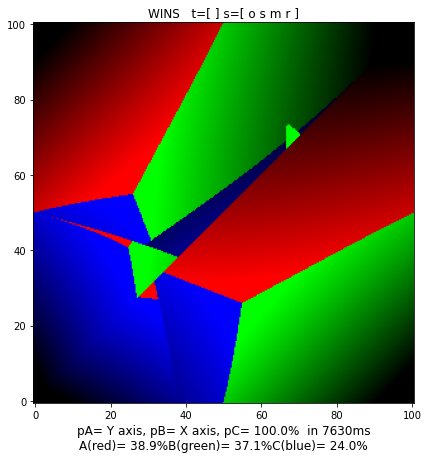

In [427]:
testAB3(search=[tg.All], AgtB=True)

['a']
['b']
['c']


<h3>Comparison between "smart" and "normal" AB methods</h3>

There are two methods available for every 'AB' function:
* **Normal method** : calculate exact value of truel() solution for every point x point case in 0<= pA,pB <=1 range.
* **Smart method** :  (default) performance optimization that does not calculate for every point. Instead, it subdivide image to smaller areas, and if area is homogenous then it interpolate values, otherwise subdivide/calculate.

Performance advantage range from moderate for small images (200 x 200), to dozens or hundreds of times for larger images ( 1000 x 1000 ) - depending not only on size of image, but also on parameters of AB function like search options etc.  
But any optimization has potential to introduce errors, so here we will use those same AB functions to analyze difference between those 'smart' and 'normal' methods.

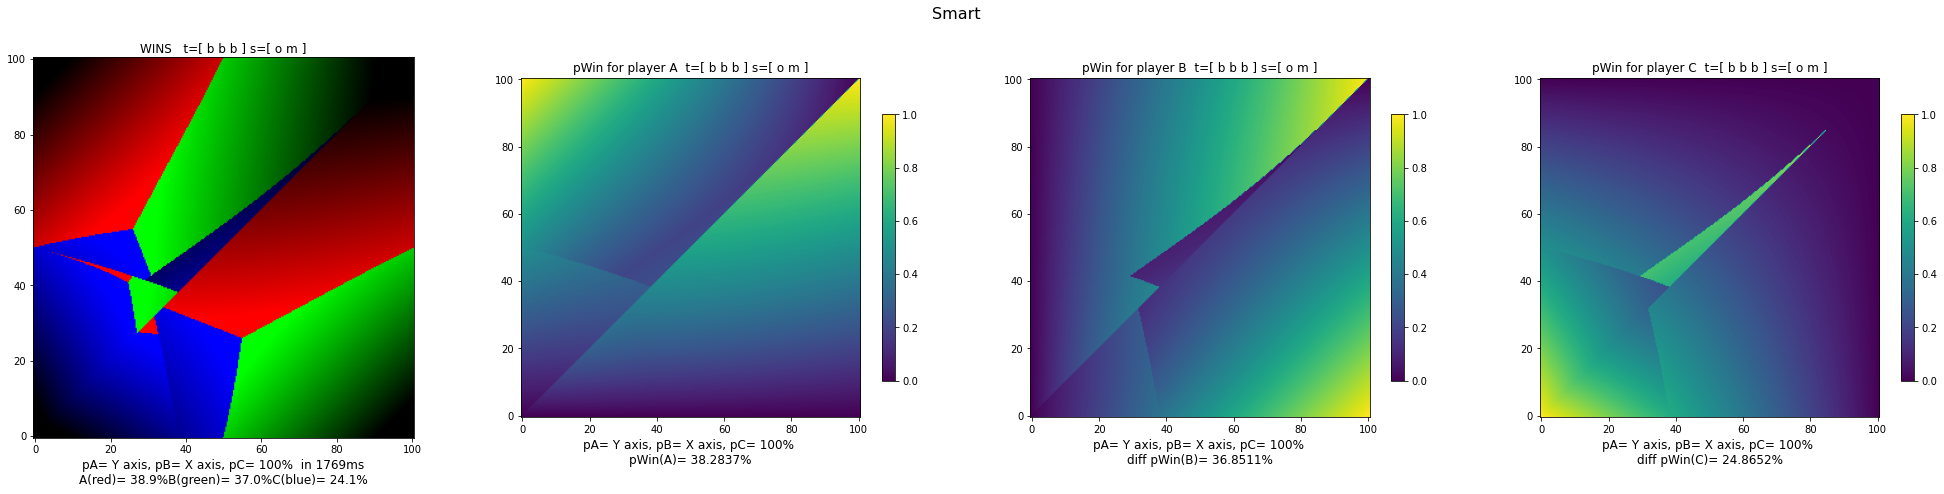

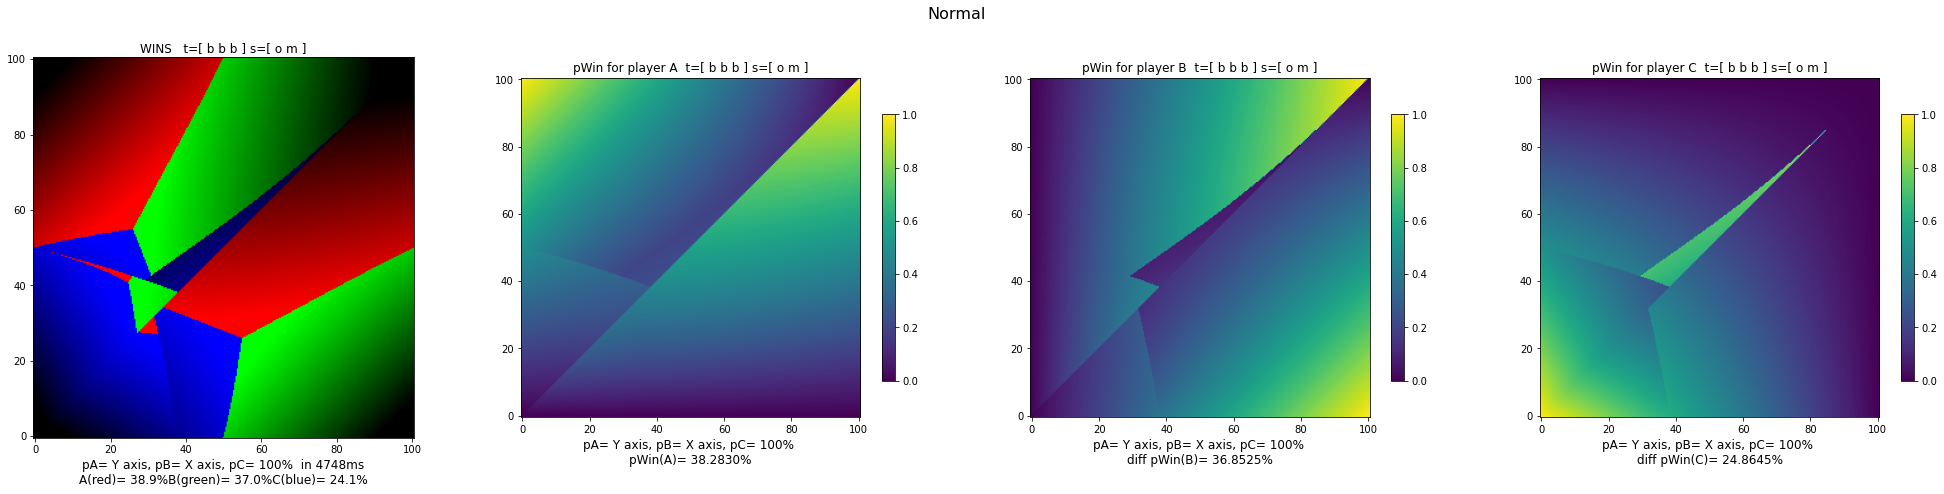

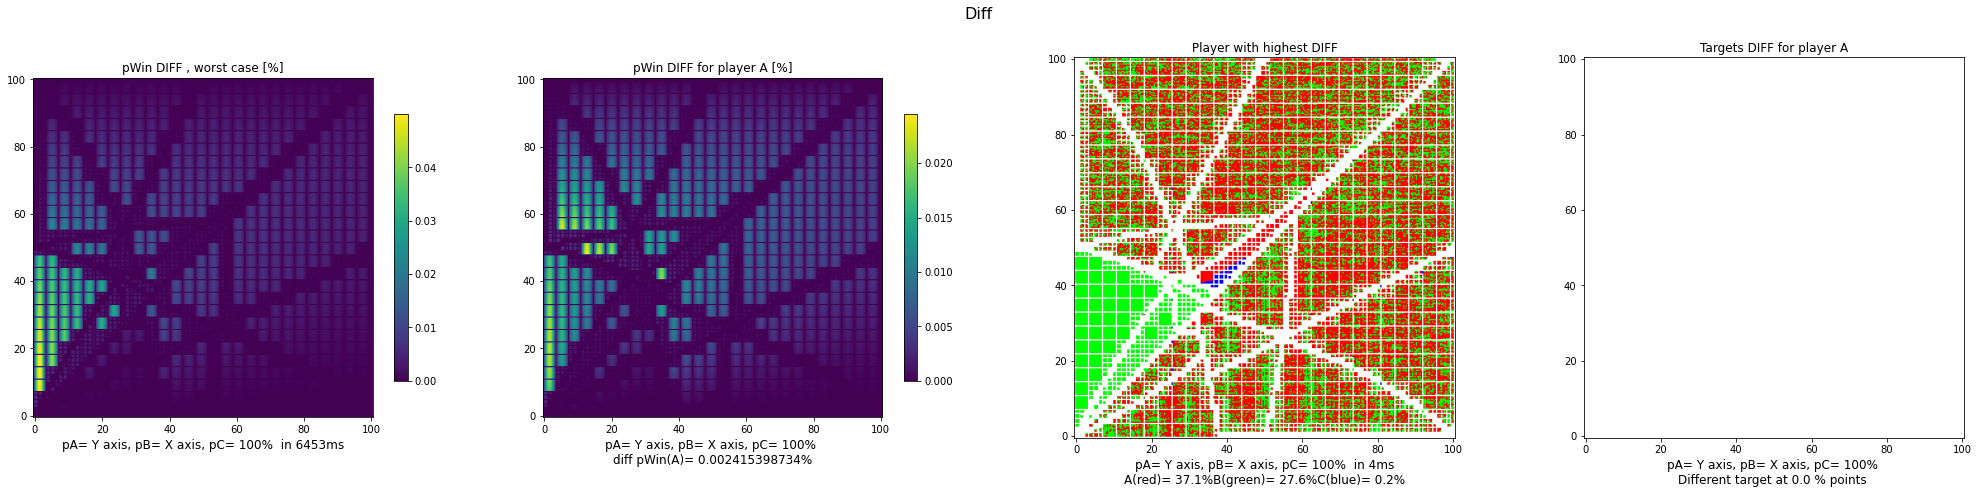

In [402]:
tSmart=Test(points=300, targets= [Optimal, Optimal, Optimal ] , search= [ Others, Miss], colors=['w','pA','pB','pC'], method="smart") 
testABt(tSmart, title="Smart")
tNormal= tSmart._replace( method="normal")
testABt(tNormal, title="Normal")
diffABt( tSmart._replace(colors=['p','pA','w','tA']), tNormal, title="Diff")

Above comparison is for standard AB image that cover any win probability for A and B ( 0<= pA,pB <= pC ; pA is on Y axis and pB is on X axis ), while pC is fixed at 100%.  
It also use standard parameters for initial targets [ Optimal, Optimal, Optimal ], meaning solution is finding optimal targets at every point, among default options [ Others, Miss ] ( so players can shoot at other players or intentionally miss )  

* First two rows shows graphs for 'smart' method (1st row), and 'normal' method (2nd row), with same type of **testABt** images per columns, or 'colors' scheme:
    1. 'w' : WINS image shows which player has higher chance to win at every point, with colors as mentioned on label under picture. It also shows time needed to calculate, so we see  that even for small 300x300 picture it is already 2.5x faster
    2. 'pA': pWin(A) shows probabilities for player A to win at each point, color coded 
    3. 'pB': pWin(B) is same for player B, , and 'average win probability' pWin(B) = expected win chance for player B if pA and pB would be randomly selected from [0% , 100%] range and player C is fixed at 100% - it is same for pWin(A) or pWin(C)
    4. 'pC': pWin(C) is same, and it can be seen that those average pWin(player) are same up to 5th decimal place , compared between 'smart' and 'normal' mode
    

* Third row directly compare two results, using **diffABt** function with same parameters as above  testABt, only with additional 'colors' schemes (they change output for diff). This analyze absolute difference of two results across entire area, both for probabilities and for optimal targets found:
     1. 'p  : pWin DIFF worst case - this is maximal difference in probability at each point, presented in percentages [%], with maximal differences going up to 0.05%
     2. 'pA': pWin DIFF for player A - shows same differences in win probabilities, but for player A. Here differences are even smaller, at max 0.02%
     3. 'w' : Player with highest DIFF - shows color for player which at that point has highest difference, regardless how small that difference is, as long as it is over zero. It shows white color where there is no difference whatsoever
     4. 'tA': Target DIFF for player A - shows at which points there is difference in found optimal target between two methods. White color means that no target difference exists at any point
     
     
Same pattern is visible on first three AB images in third row ( DIFF ):
- pattern shows rectangles, since 'smart' method subdivide image to smaller rectangles and then either interpolate or further subdivide at boundary areas
- therefore those boundary areas have highest precision, since they are mostly completely calculated. On 'p' color shcemes those are dark purple areas near 0.000, and on 'w' scheme those are white areas ( where no player has difference )
- while win probabilities have very small differences  ( around 0.02% per player ), they never influence optimal target selection or overall winner 
    

<b><h1>3. Analysis</h1></b>


<h1><br>Investigate for three players: A, B and C</h1><br>
Analyze every combination for hit chances of first two players ( A and B ), so pA=[0..1] and pB=[0..1], with fixed hit probability of third player C ( usually at pC=100%)<br>
In some cases analyze more constrained scenario where 0 < = pA < = pB < = pC , and pC==1 . In other words, first player to shoot (A) has lowest chance to hit, and last player (C) always hit. <br>

Plot will show pA on Y-axis (0% at bottom .. 100% at top ) and pB on X-axis (0% left .. 100% right ), while pC is constant at 100%<br>
Standard colors are darker for higher chance to win, and lighter for lower chance to win, and RGB color determine person who has highest chance to win:<br>
<ul style="margin-left: 30px"> 
    <li><font color=red>Red</font>:   player A has highest chance to win</li>
    <li><font color=green>Green</font>: player B has highest chance to win</li>
    <li><font color=blue>Blue</font>:  player C has highest chance to win</li>
</ul>





cmpSmartAB1(targets=[tg.Optimal,2,1]) , full image:
<ul>
<li>for points=100 : 230ms (Normal ~ 385 ms, so x1.6 ):
    - 242 ms for 30,8 (err=0.35)
    - 211 ms for 8,8  (err=2.14)
</li>
<li>for points=300 : 1080 ms (Normal ~ 3400 ms, so x3.1 ):
    - 1080 ms for min(points/8,30)=30 initial parts, and 8 max  (err=2.88)
    - 1080 ms for 30,8 (err=2.88)
    - 1200 ms for 40,8
    - 1030 ms for 8,8  (err=17.01)
    - 1100 ms for 8,18 (err 16.99)
</li>
<li>for points=1000 : 5600ms (Normal ~ 37800 ms, so x6.7 ):
    - 5660 ms for 30,8 (err=27.31)
    - 5500 ms for 8,8  (err=183.2)
</li>
<li>for points=2000 : 15sec (Normal ~ 153 sec, so x6.7 ):
    - 15110 ms for 30,8 (err=106.19 or 0.0027%)
    - 16100 ms for 50,8 (err=43.38 or 0.0011%)
</ul>

testAB([0,0,1], targets=[]). Parts=max(30,points/40). Slower, since it search optimal targets for all:
-   569 ms for  100 points
-  <b>2,820 ms</b> for  300 points
- 16,108 ms for 1000 points
- 42,774 ms for 2000 points

testAB3, with search=tg.All , so Optimal looks, in addition to Others & Miss ( 3 cases ), also to Self & Random ( so total 5 cases). Complexity jumps from 3^3 to 5^3, or x4.6 ... and so does time !
- 12,300 ms for 300 points initially
-  9,200 ms for 300 points after n==2 termination in truelC
-  9,100 ms after dictionary created once per image  ( no improvement !? )
-  8,300 ms after n==2 termination in truelC AFTER cache ( 30% orig, 10% before, improvement )
-  8,000 ms after smartRes minsize reduced from 8 to 6
-  8,300 ms after smartRes minsize reduced to 3 (!)
-  8,500 ms after smartRes minsize= 4 and parallel prange for minsize calcs ( !? parallel overhead ? )
-  7,900 ms after smartRes minsize= 4
-  7,660 ms after some further changes

In [403]:
#testAB3( colors=['w','u'], AgtB=True, search=[Others,Miss,Random] )
#testAB3( colors=['w','p','pA','pB'], AgtB=True, search=[Others,Miss,Random, Self], points=200, method="n" )



In [63]:
# random target as optimal around pA= 0.72, pB=0.68
ptruelWhy([0.72,0.68,1], search=[Others,Miss,Random])




Legend:  * = best result, at #15. m = Miss, r = Random.  Comment:  B must choose best among C+ ( those preferred by C ), and A must choose best among B+ 

    #  |  Targets |     win probabilities       |  + = max , ! = only  
-------------------------------------------------------------------------------
    1  |   r r r  |    13.2%   21.3%   32.1%    |   
    2  |   r r m  |    12.2%   21.1%   33.3%    |   C+ 
    3  |   r r A  |    11.1%   25.3%   33.2%    |   
    4  |   r r B  |    17.5%   19.3%   32.9%    |   
    5  |   r m r  |    12.8%   24.3%   29.6%    |   
    6  |   r m m  |     8.4%   24.9%   33.3%    |   C+ 
    7  |   r m A  |     6.1%   37.0%   33.0%    |   
    8  |   r m B  |    26.2%   17.9%   31.8%    |   
    9  |   r A r  |     8.2%   20.0%   44.8%    |   
   10  |   r A m  |     6.7%   19.7%   47.3%    |   C+ 
   11  |   r A A  |     6.1%   24.0%   45.9%    |   
   12  |   r A B  |    12.5%   17.9%   45.5%    |   
   13  |   r C r  |    23.3%   23.9%   25.8%    

In [ ]:
testAB3( colors='w' )

<br>When all players are shooting at higherst threat - so A and B target C, anc C target B :<br>
We see that player A can win in very small number of cases ( 4.7%, red color is dominant only in small area around pA ~ 40% and pB ~ 40% )

In [ ]:
testAB3(pC=[1,0.75,0.5,0.25], targets=[Strongest,Strongest,Strongest])
testAB3(pC=[1,0.75,0.5,0.25], targets=[C, C, B])


For size=100 (full, 4 images, after 2 cold starts )
- 1080 ms for fixResolution
- 1550 ms for smart with 30,8 , no numba


For size=500 (half, single image)
- 6000 ms before lines
- 3850 ms with lines, but before parallel
- 3848 ms with prange , but without parallel=True
- 4119 ms with prange , and parallel=True on truelN  ??!!<

<br>For size=1000 (half, single image)
- 16451 ms with prange and parallel=True
- 18721 ms with parallel=False
- 18650 ms without prange

<br>For size=1000 (half, single image), new numba and tbb
- 15288 ms without prange
- 17154 ms with prange (stil omm )

In [ ]:
ptruel( [0.4, 0.6, 1] , targets=[Strongest,Strongest,Strongest])
ptruel( [0.4, 0.6, 1] , targets=[C, C, B])


<br>When B and C are shooting at higherst threat (each other) and A intentionally miss :<br>
Here player A can win in much more cases - in fact, red area is largest at 41.1%, meaning he wins more than B or C.

In [ ]:
testAB1(targets=[tg.Miss,2,1])

In [ ]:
cmpSmartAB1(targets=[tg.Miss,2,1])

<br>When B and C are shooting at higherst threat (each other) and A chooses optimal target <br>
This does not improve much, just by 0.3% - obviously shooting to miss was optimal tactic for A in most cases anyway. Only place it improves is small additional red area around pA ~ 30% and pB ~30%

In [ ]:
testAB1(targets=[tg.Optimal,2,1])

To demonstrate that small improvement, here is calculation at pA=pB=30%, when A must miss (then C has highest chance to win, not A) and when A can choose optimal target ( targeting C, and A has highest chance to win)

In [ ]:
ptruel([0.3,0.3,1],targets=[tgMiss,2,1])
ptruel([0.3,0.3,1],targets=[tgOptimal,2,1]);

<br>When all players are allowed to select optimal target :<br>
This is exactly same as when only A was allowed to select optimal target, indicating that for B and C it is always optimal to shoot each other.

In [ ]:
testAB1()

<br><h1>But what if we look at entire area, including cases when pA > pB ? </h1><br>
Will "B and C target each other and A always miss" still be similar to "all players choosing optimal target" ? <br>
<br>
This is case when "B and C target each other and A always miss" :  player A wins in vast majority of cases (61.7%) - because others ignore him even when pA>pB <br>

In [ ]:
testAB1(targets=[tgMiss,2,1], AgtB=True)

<br>This is case when "all players choosing optimal target" :  player A now wins much less (38.9%), almost tied with B (36.7%) - since now all choose optimal target, and thus B and C fare bit better<br>
Another effect is that area is not so uniformly separated - now there are patches where different players have highest chance to win.

In [ ]:
testAB1(AgtB=True)

<br><h1>Suicide strategy :  player A is allowed to shoot himself </h1><br>

If A always shoot at himself (while all three are alive), and B/C shoot at each other, then A does not 'win' (has highest chance to win) in any area:

In [ ]:
testAB1(targets=[tgSelf,2,1])

In [ ]:
testAB1(targets=[tgRandom,2,1], search=[tgSelf, tgMiss])

<br><h1>Random strategy </h1><br>

In [ ]:
testAB1(targets=[tgRandom,2,1], search=[tgOthers])

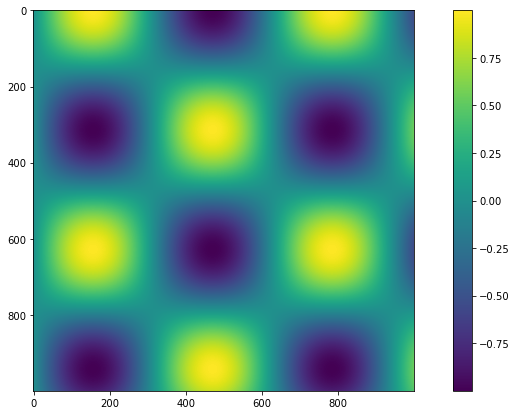

In [229]:
x = np.linspace(0, 10, 1000)
I = np.sin(x) * np.cos(x[:, np.newaxis])

plt.imshow(I)
plt.colorbar();

ToDo:
+ in truelC, add termination if players==2, to speedup process
+ targetLater=int ( Optimal | Strongest | ...) , to fill new targets with repeat(targetLater)
+ selectIFEQ= ... who to select if two equal probabilities:  min (random,miss, self,...), max, ..??

- color options for target of specific player, for example 'tA', 'tB', in addition to unusual targets 'u'. 
- color option 'dp' to show difference in probabilities (as intensity, probably just put diff_pA in red, diff_pB in green etc )
- color option 'dt' to show difference in targets ( as intensity), can try if diff_tgA, fullRed; if diff_tgB fullBlue etc
- make cmpAB function to compare two Tests, and use 'dp' and 'dt' to present

- check why random images are not same as in paper ( probably because fixed -2 does not work atm )
